## Mounting the contents of the google drive to read contents
#### As we require cuda cores, so we are using google colab, hence to deal with the I/O speed restrictions , we are firstly ziping the dataset then unzipping it


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/ComputerVision/Archive.zip .

In [3]:
!apt-get install -qq p7zip-full

In [4]:
!7z x Archive.zip -ounzipped -mmt


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2699431880 bytes (2575 MiB)

Extracting archive: Archive.zip
  4% 4096 Open              --
Path = Archive.zip
Type = zip
Physical Size = 2699431880
64-bit = +

  0%      0% 1030           0% 1639 - sentences_all/p06-069-s04-01.png                                              0% 2107 - sentences_all/g06-047g-s00-02.png                                               0% 2519 - sentences_all/e01-119-s05-01.png                                       

## Function for pre processing of the images

In [ ]:
import os
import cv2
import numpy as np

def deskew(img, max_angle_threshold=1.5):
    coords = np.column_stack(np.where(img < 255))
    if coords.shape[0] == 0:
        print(" Blank image or no text found.")
        return img

    mean, eigenvectors = cv2.PCACompute(coords.astype(np.float32), mean=np.array([]))
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0]) * 180.0 / np.pi

    print(f" Detected skew angle: {angle:.2f} degrees")

    if abs(angle) < max_angle_threshold:
        print(" Image is properly aligned.")
    else:
        print(" Image might be skewed.")

    return img  # helps to identify the deskewed images

def preprocess_image(
    image_path,
    save_path=None,
    binarize=True,
    use_bilateral=True
):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # removal of noise
    if use_bilateral:
        img = cv2.bilateralFilter(img, d=5, sigmaColor=75, sigmaSpace=75) #using biletral filter
    else:
        img = cv2.GaussianBlur(img, (3, 3), 0)

    # padding of the images
    img = cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=255)

    # check for deskew
    img = deskew(img)

    # binarization
    if binarize:
        img = cv2.adaptiveThreshold(
            img, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            31, 10
        )

    # #normalization and formattinf
    img_norm = img.astype(np.float32) / 255.0
    img_norm = np.expand_dims(img_norm, axis=0)  # [1, H, W]

    # saving of the images into th directory
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, img)

    return img_norm

def preprocess_folder(
    input_folder,
    output_folder,
    binarize=True,
    use_bilateral=True,
    out_ext=".png",
    verbose=True
):
    os.makedirs(output_folder, exist_ok=True)

    for fname in os.listdir(input_folder):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):  #taking 3 kind of format , but will be requiring png
            continue

        input_path = os.path.join(input_folder, fname)
        output_name = os.path.splitext(fname)[0] + out_ext
        output_path = os.path.join(output_folder, output_name)

        #using try excpet block -- avioiding execution error

        try:
            preprocess_image(
                image_path=input_path,
                save_path=output_path,
                binarize=binarize,
                use_bilateral=use_bilateral
            )
            if verbose:
                print(f"Processed and saved: {output_name}")
        except Exception as e:
            print(f" Failed on {fname}: {e}")

## Copying the english sentences images to one folder for faster access as the images are located in different folders and sub folders -- for ease of use

In [ ]:
import os
import shutil

#function to copy all contents into a single folder
def to_single_folder(input_folder, output_folder, extensions=(".png", ".jpg", ".jpeg")):  #as we are dealing with the images so image extensions are provided only

    os.makedirs(output_folder, exist_ok=True)
    count = 0

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(extensions):
                src_path = os.path.join(root, file)  # source path
                dst_path = os.path.join(output_folder, file)  #destination path

                # Avoid overwriting by renaming
                base, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(dst_path):
                    dst_path = os.path.join(output_folder, f"{base}_{counter}{ext}")
                    counter += 1

                shutil.copy2(src_path, dst_path)
                count += 1

    print(f"\n Finished! {count} images copied to sentences_all ") #just to ensure all images are copied to match the count

In [ ]:
# copying contents from subflolders of sentences directory to a single directory named as sentences_all
to_single_folder(
    input_folder="/content/unzipped/sentences",
    output_folder="/content/unzipped/sentences_all/"
)


 Finished! 16752 images copied to sentences_all 


## Preprocess the images i.e. the english sentences present in sentence_all dir

---



In [ ]:
# Processing the sentence images to make it ideal
preprocess_folder(
    input_folder="/content/unzipped/sentences_all/",
    output_folder="/content/unzipped/sentences_all/",
    binarize=True,
    use_bilateral=True
)

 Detected skew angle: 89.80 degrees
 Image might be skewed.
Processed and saved: b04-121-s02-01.png
 Detected skew angle: 89.08 degrees
 Image might be skewed.
Processed and saved: k07-125-s04-00.png
 Detected skew angle: 90.52 degrees
 Image might be skewed.
Processed and saved: b01-127-s01-02.png
 Detected skew angle: 89.21 degrees
 Image might be skewed.
Processed and saved: c06-116-s00-00.png
 Detected skew angle: 89.81 degrees
 Image might be skewed.
Processed and saved: l04-118-s03-01.png
 Detected skew angle: 89.33 degrees
 Image might be skewed.
Processed and saved: n02-037-s01-04.png
 Detected skew angle: 89.97 degrees
 Image might be skewed.
Processed and saved: g06-037n-s01-01.png
 Detected skew angle: 89.68 degrees
 Image might be skewed.
Processed and saved: b01-136-s01-00.png
 Detected skew angle: 89.57 degrees
 Image might be skewed.
Processed and saved: g06-037b-s02-03.png
 Detected skew angle: 89.50 degrees
 Image might be skewed.
Processed and saved: n02-098-s01-01.pn

## Creation of Matadata for English sentences

In [ ]:
import os
import csv
import concurrent.futures

# function  that scans base and subfolders, returns {form_id: , full_image_path}
def scan_images(image_base_folder):

    all_images = {}

    def scan_folder(folder):
        sub_images = {}
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.jpeg', '.jpg', '.png')):
                    form_id = os.path.splitext(file)[0].lower()
                    sub_images[form_id] = os.path.join(root, file)
        return sub_images

    #  Scan base folder + any subdirectories
    scan_targets = [image_base_folder] + [
        os.path.join(image_base_folder, sub)
        for sub in os.listdir(image_base_folder)
        if os.path.isdir(os.path.join(image_base_folder, sub))
    ]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(scan_folder, folder) for folder in scan_targets]
        for future in concurrent.futures.as_completed(futures):
            all_images.update(future.result())

    return all_images


# Parses sentences.txt and builds a metadata CSV with: form_id, image_path, printed_transcription, language using multi threading
def create_metadata(sentence_txt_path, image_base_folder, output_csv_path):

    print("<---- Scanning image folders ----->")
    image_paths = scan_images(image_base_folder)
    print(f" Found {len(image_paths)} image files")

    dataset = []

    with open(sentence_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()
            if len(parts) < 9:
                continue

            form_id = parts[0].lower()  # normalization
            text_tokens = parts[8:]
            clean_tokens = [t for t in text_tokens if not t.isdigit()]
            text = " ".join(clean_tokens).replace("|", " ")

            if form_id in image_paths:
                dataset.append([form_id, image_paths[form_id], text, "english"])
            else:
                print(f" Image not found for: {form_id}")

    # Saving the CSV
    with open(output_csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["form_id", "image_path", "transcription", "language"])
        writer.writerows(dataset)

    print(f"Sentence metadata saved to: {output_csv_path}")

In [ ]:
# creating metadata of the english sentences and saving as the Sentence_Metadata.csv
create_metadata(
    sentence_txt_path="/content/unzipped/ascii/sentences.txt",
    image_base_folder="/content/unzipped/sentences_all/",
    output_csv_path="Sentence_Metadata.csv"
)

<---- Scanning image folders ----->
 Found 16752 image files
Sentence metadata saved to: Sentence_Metadata.csv


## Dataframe of English Sentences: sentence_df

In [ ]:
import pandas as pd

# reading the Sentence_Metadata.csv and creating the metadata, which is useful for future operations
sentence_df = pd.read_csv("Sentence_Metadata.csv")

#vizualizing the sentence_df , necessary for the debugging
sentence_df

form_id                                         image_path  \
0      a01-000u-s00-00  /content/unzipped/sentences_all/a01-000u-s00-0...   
1      a01-000u-s00-01  /content/unzipped/sentences_all/a01-000u-s00-0...   
2      a01-000u-s00-02  /content/unzipped/sentences_all/a01-000u-s00-0...   
3      a01-000u-s00-03  /content/unzipped/sentences_all/a01-000u-s00-0...   
4      a01-000u-s01-00  /content/unzipped/sentences_all/a01-000u-s01-0...   
...                ...                                                ...   
16747   r06-143-s01-01  /content/unzipped/sentences_all/r06-143-s01-01...   
16748   r06-143-s02-00  /content/unzipped/sentences_all/r06-143-s02-00...   
16749   r06-143-s03-00  /content/unzipped/sentences_all/r06-143-s03-00...   
16750   r06-143-s04-00  /content/unzipped/sentences_all/r06-143-s04-00...   
16751   r06-143-s04-01  /content/unzipped/sentences_all/r06-143-s04-01...   

                                         transcription language  
0                    A MOVE to stop Mr. Gaitskell from  english  
1                nominating any more Labour life Peers  english  
2                 is to be made at a meeting of Labour  english  
3                                      M Ps tomorrow .  english  
4                                 Mr. Michael Foot has  english  
...                                                ...      ...  
16747                 in front of her , but she said :  english  
16748                      ' Philip 's awfully lucky .  english  
16749                   I wish I went to that school .  english  
16750                                   Did you notice  english  
16751  that girl who said hullo to him in the garden ?  english  

[16752 rows x 4 columns]

## Augumentation of English Sentences and seprate Metadata creation of those images

<ipython-input-8-f30984e73df2>:12: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=2.0, p=0.5),  # Soft Gaussian noise
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:231: UserWarning: blur_limit: Invalid kernel size range (3, 1). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)
<ipython-input-8-f30984e73df2>:20: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=92, quality_upper=98, p=0.2), #compression of image
100%|██████████| 16752/16752 [00:17<00:00, 973.78it/s] 


 Augmented dataset saved to: augmented_only.csv


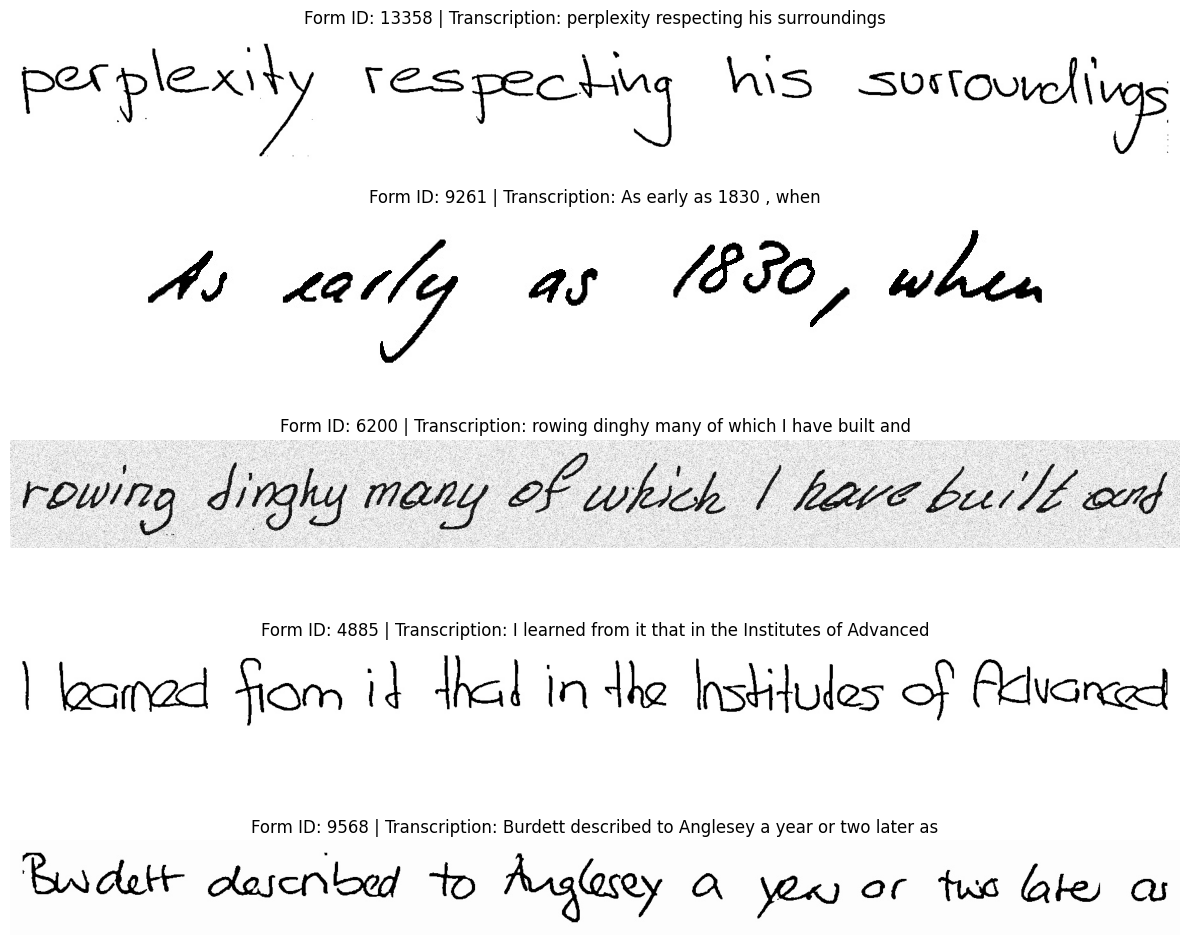

In [ ]:
import os
import cv2
import albumentations as A
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

# the parameters for augumentation
ocr_augment = A.Compose([
    A.OneOf([
        A.GaussNoise(mean=0, std=2.0, p=0.5),  # Soft Gaussian noise
        A.ISONoise(color_shift=(0.001, 0.003), intensity=(0.01, 0.03), p=0.5),  # ISO noise
    ], p=0.2),
    A.MotionBlur(blur_limit=1, p=0.1), # adding motion blur
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.01, contrast_limit=0.01, p=0.7), #adding random brightness and contrast
        A.CLAHE(clip_limit=1.0, p=0.3),  # Valid lower limit
    ], p=0.3),
    A.ImageCompression(quality_lower=92, quality_upper=98, p=0.2), #compression of image
])

# Output directory
os.makedirs("augmented_images", exist_ok=True)

# Augmentation function
def augumentation(index_row):
    index, row = index_row
    try:
        # Read in grayscale
        img = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None

        # Convert grayscale to RGB tfor preserving the white borders
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Applying the augmentation in RGB
        aug_img_rgb = ocr_augment(image=img_rgb)["image"]

        # Converting back to grayscale
        aug_img = cv2.cvtColor(aug_img_rgb, cv2.COLOR_RGB2GRAY)

        # Saving
        base_name = os.path.splitext(os.path.basename(row["image_path"]))[0]
        new_filename = f"{base_name}_aug_{index}.jpg"
        new_path = os.path.join("augmented_images", new_filename)
        cv2.imwrite(new_path, aug_img)

        return {
            "form_id": str(index),
            "image_path": new_path,
            "transcription": row["transcription"],
            "language": "english"
        }
        #returning in the same and adding the language column , as we are dealing here with english only so we are adding english in all rows for sentence_df
        #also creates metadata of the augumented images

    except Exception as e:
        print(f" Error processing {row.get('image_path', 'unknown')}: {e}")
        return None

# loding original DataFrame
sentence_df = sentence_df.reset_index(drop=True)
indexed_rows = list(sentence_df.iterrows())

# running in the parallel
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(augumentation, indexed_rows, chunksize=10), total=len(indexed_rows)))

# Creating DataFrame from results
augmented_records = [r for r in results if r is not None]
aug_df = pd.DataFrame(augmented_records)

# saving in csv form
aug_df.to_csv("augmented_only.csv", index=False)
print(" Augmented dataset saved to: augmented_only.csv")

# Preview 5 random samples
plt.figure(figsize=(12, 10))
for i in range(5):
    row = aug_df.sample(1).iloc[0]
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.title(f"Form ID: {row['form_id']} | Transcription: {row['transcription']}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
aug_df

form_id                                     image_path  \
0           0     augmented_images/a01-000u-s00-00_aug_0.jpg   
1           1     augmented_images/a01-000u-s00-01_aug_1.jpg   
2           2     augmented_images/a01-000u-s00-02_aug_2.jpg   
3           3     augmented_images/a01-000u-s00-03_aug_3.jpg   
4           4     augmented_images/a01-000u-s01-00_aug_4.jpg   
...       ...                                            ...   
16747   16747  augmented_images/r06-143-s01-01_aug_16747.jpg   
16748   16748  augmented_images/r06-143-s02-00_aug_16748.jpg   
16749   16749  augmented_images/r06-143-s03-00_aug_16749.jpg   
16750   16750  augmented_images/r06-143-s04-00_aug_16750.jpg   
16751   16751  augmented_images/r06-143-s04-01_aug_16751.jpg   

                                         transcription language  
0                    A MOVE to stop Mr. Gaitskell from  english  
1                nominating any more Labour life Peers  english  
2                 is to be made at a meeting of Labour  english  
3                                      M Ps tomorrow .  english  
4                                 Mr. Michael Foot has  english  
...                                                ...      ...  
16747                 in front of her , but she said :  english  
16748                      ' Philip 's awfully lucky .  english  
16749                   I wish I went to that school .  english  
16750                                   Did you notice  english  
16751  that girl who said hullo to him in the garden ?  english  

[16752 rows x 4 columns]

In [ ]:
import pandas as pd
import string

aug_df = pd.read_csv("augmented_only.csv")

#performing concatenation and rewriting to sentence_df
sentence_df = pd.concat([sentence_df, aug_df], ignore_index=True)

# adding normalization of text, all in the lower case and removing the punctuation from the transcription
def normalize_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    return text.strip()

sentence_df["transcription"] = sentence_df["transcription"].astype(str).apply(normalize_text)

#saving as csv
sentence_df.to_csv("Sentence_Metadata.csv", index=False)

print("sentence_df merged, normalized, and saved to 'Sentence_Metadata.csv'")

sentence_df merged, normalized, and saved to 'Sentence_Metadata.csv'


In [ ]:
sentence_df

form_id                                         image_path  \
0      a01-000u-s00-00  /content/unzipped/sentences_all/a01-000u-s00-0...   
1      a01-000u-s00-01  /content/unzipped/sentences_all/a01-000u-s00-0...   
2      a01-000u-s00-02  /content/unzipped/sentences_all/a01-000u-s00-0...   
3      a01-000u-s00-03  /content/unzipped/sentences_all/a01-000u-s00-0...   
4      a01-000u-s01-00  /content/unzipped/sentences_all/a01-000u-s01-0...   
...                ...                                                ...   
33499            16747      augmented_images/r06-143-s01-01_aug_16747.jpg   
33500            16748      augmented_images/r06-143-s02-00_aug_16748.jpg   
33501            16749      augmented_images/r06-143-s03-00_aug_16749.jpg   
33502            16750      augmented_images/r06-143-s04-00_aug_16750.jpg   
33503            16751      augmented_images/r06-143-s04-01_aug_16751.jpg   

                                       transcription language  
0                   a move to stop mr gaitskell from  english  
1              nominating any more labour life peers  english  
2               is to be made at a meeting of labour  english  
3                                      m ps tomorrow  english  
4                                mr michael foot has  english  
...                                              ...      ...  
33499                  in front of her  but she said  english  
33500                         philip s awfully lucky  english  
33501                   i wish i went to that school  english  
33502                                 did you notice  english  
33503  that girl who said hullo to him in the garden  english  

[33504 rows x 4 columns]

## Reading paragraph images with the ground truth

### Importent ----> This data containing 1539 rows is not included in training lately, because as per our finidings  we decided not to not include this data for training further explanation is in the report <-----

In [ ]:
import os
import csv
import concurrent.futures
from collections import defaultdict

# defining the paths
base_folder = "/content/unzipped/"  # it is our base/ parent directory of sub directories
lines_txt_path = "/content/unzipped/ascii/lines.txt"
output_csv = "Handwriting_1_matadata.csv"

# parsing the lines.txt
form_lines = defaultdict(list)

with open(lines_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.startswith("#") or not line.strip():
            continue
        parts = line.strip().split()
        line_id = parts[0]
        form_id = "-".join(line_id.split("-")[:2])
        text = " ".join(parts[8:]).replace("|", " ")
        form_lines[form_id].append(text)

# scan all the folders for Images
def scan_for_images(folder):
    img_paths = {}
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith((".png", ".jpeg", ".jpg")):
                form_id = os.path.splitext(file)[0]
                img_paths[form_id] = os.path.join(root, file)
    return img_paths

# Use multithreading for scanning to enhance performance and reduce the execution time
form_image_paths = {}

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(scan_for_images, os.path.join(base_folder, subfolder))
               for subfolder in os.listdir(base_folder)
               if subfolder.startswith("forms")]
    for future in concurrent.futures.as_completed(futures):
        form_image_paths.update(future.result())

# building the metadata
dataset = []

for form_id, lines in form_lines.items():
    if form_id in form_image_paths:
        image_path = form_image_paths[form_id]
        text = " ".join(lines)
        dataset.append([form_id, image_path, text, "english"])

# Step 4: Write to CSV
with open(output_csv, "w", newline="", encoding="utf-8") as out_file:
    writer = csv.writer(out_file)
    writer.writerow(["form_id", "image_path", "transcription", "language"])  # ✅ Updated header
    writer.writerows(dataset)

print(f"Dataset saved to: {output_csv}")

Dataset saved to: Handwriting_1_matadata.csv


### Cropping the images to capture Handwritten part

#### Cropping the Handwritten section only of the full pages as the pages also includes the printed region that is not present in the ground truth

#### ---> but again this is not part of training , coz it is making result worse


In [ ]:
import os
import cv2
import numpy as np

def extract_handwritten(image_path, ignore_top_ratio=0.15):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape

    # Threshold to binary
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Ignoring the top printed lines
    binary[:int(h * ignore_top_ratio), :] = 0

    # contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Bounding box
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + bw)
        y_max = max(y_max, y + bh)

    if x_max - x_min < 10 or y_max - y_min < 10:
        return None  # Too small

    cropped = img[y_min:y_max, x_min:x_max]
    return cropped


def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    processed_count = 0
    skipped_count = 0

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            cropped = extract_handwritten(input_path)
            if cropped is not None and cropped.size > 0:
                cv2.imwrite(output_path, cropped)
                processed_count += 1
            else:
                skipped_count += 1

    print(f"Processed: {processed_count} images")
    print(f"Skipped: {skipped_count} images (no handwritten region found)")

#### processing Images of the english full forms and removing the printed section from the forms
#### ----> lately decided not to include this , coz it is making result worse

In [ ]:
# preprocessing images of directory formsA-D
preprocess_folder(
    input_folder="/content/unzipped/formsA-D ",
    output_folder="/content/unzipped/formsA-D ",
    binarize=True,
    use_bilateral=True
)

 Detected skew angle: -6.94 degrees
 Image might be skewed.
Processed and saved: a04-006.png
 Detected skew angle: -18.64 degrees
 Image might be skewed.
Processed and saved: c03-087e.png
 Detected skew angle: -3.36 degrees
 Image might be skewed.
Processed and saved: a02-057.png
 Detected skew angle: -16.47 degrees
 Image might be skewed.
Processed and saved: d07-082.png
 Detected skew angle: -7.32 degrees
 Image might be skewed.
Processed and saved: d07-096.png
 Detected skew angle: -8.64 degrees
 Image might be skewed.
Processed and saved: a05-017.png
 Detected skew angle: -6.30 degrees
 Image might be skewed.
Processed and saved: b04-026.png
 Detected skew angle: -26.33 degrees
 Image might be skewed.
Processed and saved: d06-050.png
 Detected skew angle: -1.82 degrees
 Image might be skewed.
Processed and saved: c06-020.png
 Detected skew angle: -8.58 degrees
 Image might be skewed.
Processed and saved: d05-030.png
 Detected skew angle: -5.88 degrees
 Image might be skewed.
Proces

In [ ]:
# removing printed section from images of directory formsA-D
input_folder = "/content/unzipped/formsA-D "
output_folder = "/content/unzipped/formsA-D "
process_folder(input_folder, output_folder)

Processed: 529 images
Skipped: 0 images (no handwritten region found)


In [ ]:
# preprocessing images of directory formsI-Z
preprocess_folder(
    input_folder="/content/unzipped/formsI-Z",
    output_folder="/content/unzipped/formsI-Z",
    binarize=True,
    use_bilateral=True
)

 Detected skew angle: -10.78 degrees
 Image might be skewed.
Processed and saved: k04-061.png
 Detected skew angle: -13.17 degrees
 Image might be skewed.
Processed and saved: k04-075.png
 Detected skew angle: -7.14 degrees
 Image might be skewed.
Processed and saved: l07-111.png
 Detected skew angle: -0.78 degrees
 Image is properly aligned.
Processed and saved: k02-018.png
 Detected skew angle: -2.84 degrees
 Image might be skewed.
Processed and saved: l04-005.png
 Detected skew angle: -23.40 degrees
 Image might be skewed.
Processed and saved: p03-163.png
 Detected skew angle: -6.34 degrees
 Image might be skewed.
Processed and saved: r06-111.png
 Detected skew angle: -3.83 degrees
 Image might be skewed.
Processed and saved: m04-072.png
 Detected skew angle: -1.01 degrees
 Image is properly aligned.
Processed and saved: n06-194.png
 Detected skew angle: -15.70 degrees
 Image might be skewed.
Processed and saved: k04-115.png
 Detected skew angle: -3.32 degrees
 Image might be skewed

In [ ]:
# removing printed section from images of directory formsI-Z
input_folder = "/content/unzipped/formsI-Z"
output_folder = "/content/unzipped/formsI-Z"
process_folder(input_folder, output_folder)

Processed: 488 images
Skipped: 0 images (no handwritten region found)


In [ ]:
# preprocessing images of directory formsE-H
preprocess_folder(
    input_folder="/content/unzipped/formsE-H",
    output_folder="/content/unzipped/formsE-H",
    binarize=True,
    use_bilateral=True
)

 Detected skew angle: 0.72 degrees
 Image is properly aligned.
Processed and saved: f02-033.png
 Detected skew angle: -7.42 degrees
 Image might be skewed.
Processed and saved: g06-037m.png
 Detected skew angle: -8.79 degrees
 Image might be skewed.
Processed and saved: g06-042p.png
 Detected skew angle: -18.60 degrees
 Image might be skewed.
Processed and saved: g06-042g.png
 Detected skew angle: -14.51 degrees
 Image might be skewed.
Processed and saved: e04-095.png
 Detected skew angle: -9.72 degrees
 Image might be skewed.
Processed and saved: h04-055.png
 Detected skew angle: -12.39 degrees
 Image might be skewed.
Processed and saved: e01-107.png
 Detected skew angle: -18.99 degrees
 Image might be skewed.
Processed and saved: e01-113.png
 Detected skew angle: -17.27 degrees
 Image might be skewed.
Processed and saved: h02-004.png
 Detected skew angle: -7.28 degrees
 Image might be skewed.
Processed and saved: h04-082.png
 Detected skew angle: -0.85 degrees
 Image is properly alig

In [ ]:
# removing printed section from images of directory formsE-H
input_folder = "/content/unzipped/formsE-H"
output_folder = "/content/unzipped/formsE-H"
process_folder(input_folder, output_folder)

Processed: 522 images
Skipped: 0 images (no handwritten region found)


#### Creating Dataframe for Full text of engligh handwritten
#### ----->> not included for training

In [ ]:
import pandas as pd
english_df = pd.read_csv("Handwriting_1_matadata.csv")

In [ ]:
english_df

form_id                                image_path  \
0     a01-000u  /content/unzipped/formsA-D /a01-000u.png   
1     a01-000x  /content/unzipped/formsA-D /a01-000x.png   
2      a01-003   /content/unzipped/formsA-D /a01-003.png   
3     a01-003u  /content/unzipped/formsA-D /a01-003u.png   
4     a01-003x  /content/unzipped/formsA-D /a01-003x.png   
...        ...                                       ...   
1534   r06-121    /content/unzipped/formsI-Z/r06-121.png   
1535   r06-126    /content/unzipped/formsI-Z/r06-126.png   
1536   r06-130    /content/unzipped/formsI-Z/r06-130.png   
1537   r06-137    /content/unzipped/formsI-Z/r06-137.png   
1538   r06-143    /content/unzipped/formsI-Z/r06-143.png   

                                          transcription language  
0     A MOVE to stop Mr. Gaitskell from nominating a...  english  
1     A MOVE to stop Mr. Gaitskell from nominating a...  english  
2     Though they may gather some Left-wing support ...  english  
3     Though they may gather some Left-wing support ...  english  
4     Though they may gather some Left-wing support ...  english  
...                                                 ...      ...  
1534  At the school , which is charming , ci- vilise...  english  
1535  For his sake we chose the more serious of the ...  english  
1536  At the entrance of the cinema the doorman was ...  english  
1537  The doorman turned his attention to the next r...  english  
1538  In the train going back to London I sat beside...  english  

[1539 rows x 4 columns]

## Metadata for Hindi language: PRINTED hindi sentences

In [ ]:
import os
import csv

def scan_images(image_folder): #this time we are not adding to scan the sub folder as it is not required
    images = {}
    for file in os.listdir(image_folder):
        if file.lower().endswith(('.jpeg', '.jpg', '.png')):
            form_id = os.path.splitext(file)[0].lower()
            images[form_id] = os.path.join(image_folder, file)
    return images


# creating hindi sentences metadata
def create_metadata(sentence_txt_path, image_folder, output_csv_path):
    print(" Scanning image folder...")
    image_paths = scan_images(image_folder)
    print(f" Found {len(image_paths)} images")

    dataset = []
    skipped = 0

    with open(sentence_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()
            if len(parts) < 2:
                continue

            form_id = os.path.splitext(parts[0])[0].lower()

            transcription_tokens = [
                t for t in parts[1:]
                if not t.isdigit() and not t.endswith(('.ttf', '.otf')) and "." not in t
            ]

            transcription = " ".join(transcription_tokens).replace("|", " ")

            if form_id in image_paths and transcription.strip():
                dataset.append([form_id, image_paths[form_id], transcription, "hindi"])
            else:
                skipped += 1

    # Writing CSV with only the required columns as there were many other columns in the grouthtruth filr and adding language as "hindi" in this case
    with open(output_csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["form_id", "image_path", "transcription", "language"])
        writer.writerows(dataset)

    print(f"\nMetadata saved to: {output_csv_path}")
    print(f" Total matched entries: {len(dataset)}")
    print(f" Skipped entries (missing image or transcription): {skipped}")


In [ ]:
#creating metadata for all the hindi samples
if __name__ == "__main__":
    create_metadata(
        sentence_txt_path="/content/unzipped/data.csv",
        image_folder="/content/unzipped/output_images",
        output_csv_path="hindi_metadata.csv"
    )

 Scanning image folder...
 Found 5500 images

Metadata saved to: hindi_metadata.csv
 Total matched entries: 5500
 Skipped entries (missing image or transcription): 0


## Preprocess the Hindi Original Images

In [ ]:
# preprocessing the image to make it fit for the training
preprocess_folder(
    input_folder="/content/unzipped/output_images",
    output_folder="/content/unzipped/output_images",
    binarize=True,
    use_bilateral=True
)

 Detected skew angle: 90.02 degrees
 Image might be skewed.
Processed and saved: 69351.png
 Detected skew angle: 89.93 degrees
 Image might be skewed.
Processed and saved: 39566.png
 Detected skew angle: 89.96 degrees
 Image might be skewed.
Processed and saved: 53967.png
 Detected skew angle: 90.05 degrees
 Image might be skewed.
Processed and saved: 1804.png
 Detected skew angle: 90.00 degrees
 Image might be skewed.
Processed and saved: 39214.png
 Detected skew angle: 90.01 degrees
 Image might be skewed.
Processed and saved: 26334.png
 Detected skew angle: 90.02 degrees
 Image might be skewed.
Processed and saved: 64661.png
 Detected skew angle: 90.09 degrees
 Image might be skewed.
Processed and saved: 69345.png
 Detected skew angle: 89.88 degrees
 Image might be skewed.
Processed and saved: 1186.png
 Detected skew angle: 90.04 degrees
 Image might be skewed.
Processed and saved: 412.png
 Detected skew angle: 89.92 degrees
 Image might be skewed.
Processed and saved: 40927.png
 De

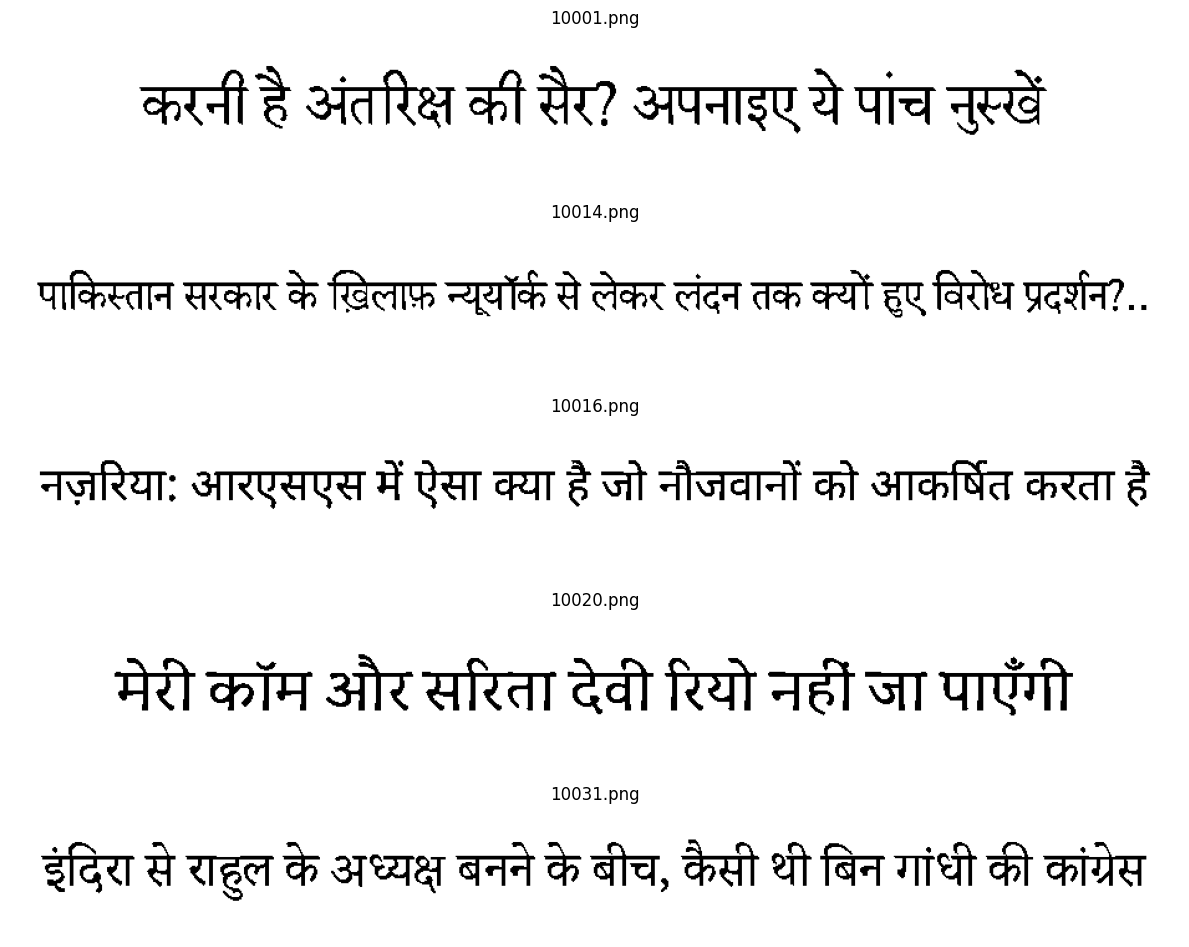

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Function for showing the image samples from the images
def show_images(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = sorted(image_files)[:num_images]

    plt.figure(figsize=(12, num_images * 2))

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.title(filename)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Calling the function
show_images("/content/unzipped/output_images", num_images=5)

In [ ]:
import pandas as pd

#creating the dataframe for the hindi samples (without augumentation)
hindi_df = pd.read_csv("hindi_metadata.csv")
hindi_df

form_id                                 image_path  \
0           2      /content/unzipped/output_images/2.png   
1          20     /content/unzipped/output_images/20.png   
2          34     /content/unzipped/output_images/34.png   
3          35     /content/unzipped/output_images/35.png   
4          47     /content/unzipped/output_images/47.png   
...       ...                                        ...   
5495    79968  /content/unzipped/output_images/79968.png   
5496    79973  /content/unzipped/output_images/79973.png   
5497    79974  /content/unzipped/output_images/79974.png   
5498    79976  /content/unzipped/output_images/79976.png   
5499    79983  /content/unzipped/output_images/79983.png   

                                          transcription language  
0     ख़ुदा का घर है तो यह ईमान वाली स्‍त्र‍ियों के ...    hindi  
1     और फ़लस्तीनियों में छिड़े ख़ूनी संघर्ष पर सामन...    hindi  
2     में हिंसाः केजरीवाल ट्वीट करने से ज़्यादा क्या...    hindi  
3                      होता है सैकड़ों लाशों को पानी से    hindi  
4               में कौन था' बनाने वाले यशराज मुखाते कौन    hindi  
...                                                 ...      ...  
5495                ने दिलाई किंग्स इलेवन और कोलकाता को    hindi  
5496                         से छूटे तो 'पानी की कमी से    hindi  
5497  आंदोलन: लौट जाएगा किसान संगठनों को विदेश से भे...    hindi  
5498  नाइक और मलेशियाई राज्य के उपमुख्यमंत्री रामासा...    hindi  
5499         चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक    hindi  

[5500 rows x 4 columns]

## Augumentation of the Hindi Image samples and creating the Metadata for the augumented samples

<ipython-input-16-14135ab5094d>:12: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=2.0, p=0.5),  # Soft Gaussian noise
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:231: UserWarning: blur_limit: Invalid kernel size range (3, 1). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)
<ipython-input-16-14135ab5094d>:20: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=92, quality_upper=98, p=0.2), #adding image compression
100%|██████████| 5500/5500 [00:02<00:00, 1906.78it/s]


Hindi augmented dataset saved to augmented_hindi_only.csv


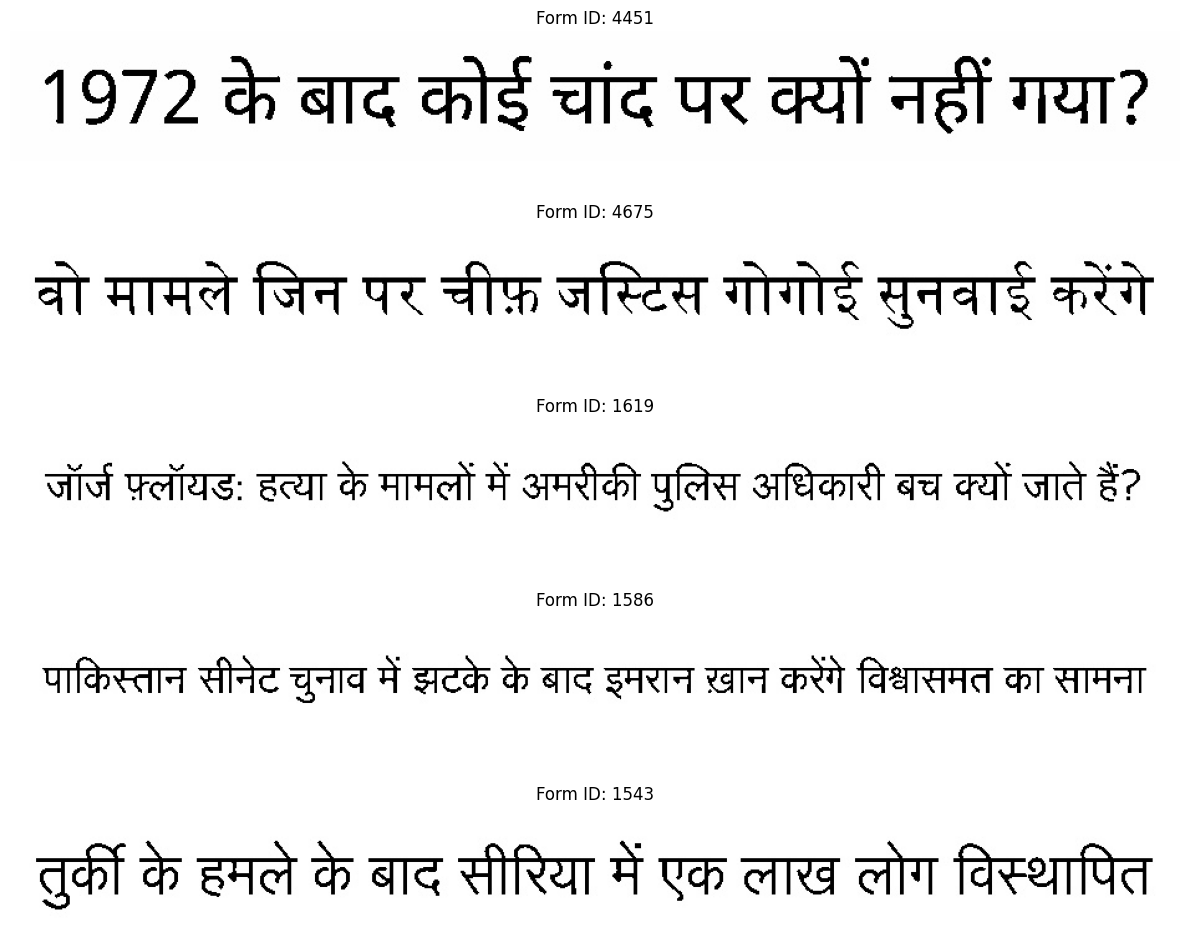

In [ ]:
import os
import cv2
import albumentations as A
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

# augumentation hyperparameters
ocr_augment = A.Compose([
    A.OneOf([
        A.GaussNoise(mean=0, std=2.0, p=0.5),  # Soft Gaussian noise
        A.ISONoise(color_shift=(0.001, 0.003), intensity=(0.01, 0.03), p=0.5),  # Gentle ISO noise
    ], p=0.2),
    A.MotionBlur(blur_limit=1, p=0.1), #motion blur
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.01, contrast_limit=0.01, p=0.7),
        A.CLAHE(clip_limit=1.0, p=0.3),  # Valid lower limit
    ], p=0.3),
    A.ImageCompression(quality_lower=92, quality_upper=98, p=0.2), #adding image compression
])

# Output directory
os.makedirs("augmented_images_hindi", exist_ok=True)

# === Augmentation function
def augumentation_hindi(index_row):
    index, row = index_row
    try:
        img = cv2.imread(row["image_path"])
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug_img = ocr_augment(image=img)["image"]

        base_name = os.path.splitext(os.path.basename(row["image_path"]))[0]
        new_filename = f"{base_name}_aug_hi_{index}.jpg"
        new_path = os.path.join("augmented_images_hindi", new_filename)
        cv2.imwrite(new_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        return {
            "form_id": str(index),
            "image_path": new_path,
            "transcription": row["transcription"],
            "language": "hindi" #adding hindi to the returned csv for Metadata
        }
    except:
        return None


hindi_df = hindi_df.reset_index(drop=True)
indexed_rows = list(hindi_df.iterrows())

#using multothreading to speed up the process
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(augumentation_hindi, indexed_rows, chunksize=10), total=len(indexed_rows)))

# dataframe for the augumented result
augmented_records = [r for r in results if r is not None]
aug_hindi_df = pd.DataFrame(augmented_records)

# saving of the path transcription and the language
aug_hindi_df.to_csv("augmented_hindi_only.csv", index=False)
print("Hindi augmented dataset saved to augmented_hindi_only.csv")

#showing 5 random samples
plt.figure(figsize=(12, 10))
for i in range(5):
    row = aug_hindi_df.sample(1).iloc[0]
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.title(f"Form ID: {row['form_id']}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
hindi_df

form_id                                 image_path  \
0           2      /content/unzipped/output_images/2.png   
1          20     /content/unzipped/output_images/20.png   
2          34     /content/unzipped/output_images/34.png   
3          35     /content/unzipped/output_images/35.png   
4          47     /content/unzipped/output_images/47.png   
...       ...                                        ...   
5495    79968  /content/unzipped/output_images/79968.png   
5496    79973  /content/unzipped/output_images/79973.png   
5497    79974  /content/unzipped/output_images/79974.png   
5498    79976  /content/unzipped/output_images/79976.png   
5499    79983  /content/unzipped/output_images/79983.png   

                                          transcription language  
0     ख़ुदा का घर है तो यह ईमान वाली स्‍त्र‍ियों के ...    hindi  
1     और फ़लस्तीनियों में छिड़े ख़ूनी संघर्ष पर सामन...    hindi  
2     में हिंसाः केजरीवाल ट्वीट करने से ज़्यादा क्या...    hindi  
3                      होता है सैकड़ों लाशों को पानी से    hindi  
4               में कौन था' बनाने वाले यशराज मुखाते कौन    hindi  
...                                                 ...      ...  
5495                ने दिलाई किंग्स इलेवन और कोलकाता को    hindi  
5496                         से छूटे तो 'पानी की कमी से    hindi  
5497  आंदोलन: लौट जाएगा किसान संगठनों को विदेश से भे...    hindi  
5498  नाइक और मलेशियाई राज्य के उपमुख्यमंत्री रामासा...    hindi  
5499         चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक    hindi  

[5500 rows x 4 columns]

In [ ]:
import pandas as pd
import unicodedata

#loding the augumented csv file for df
aug_hindi_df = pd.read_csv("augmented_hindi_only.csv")

# merding and overwriting
hindi_df = pd.concat([hindi_df, aug_hindi_df], ignore_index=True)

# performing normalization of the texts
def normalize_hindi(text):
    if pd.isna(text):
        return ""
    return unicodedata.normalize("NFKC", text).strip()

hindi_df["transcription"] = hindi_df["transcription"].astype(str).apply(normalize_hindi)

# saving as csv
hindi_df.to_csv("hindi_metadata.csv", index=False)

print(" hindi_df merged, normalized, and saved to 'hindi_metadata.csv'")

 hindi_df merged, normalized, and saved to 'hindi_metadata.csv'


In [ ]:
hindi_df

form_id                                    image_path  \
0            2         /content/unzipped/output_images/2.png   
1           20        /content/unzipped/output_images/20.png   
2           34        /content/unzipped/output_images/34.png   
3           35        /content/unzipped/output_images/35.png   
4           47        /content/unzipped/output_images/47.png   
...        ...                                           ...   
10995     5495  augmented_images_hindi/79968_aug_hi_5495.jpg   
10996     5496  augmented_images_hindi/79973_aug_hi_5496.jpg   
10997     5497  augmented_images_hindi/79974_aug_hi_5497.jpg   
10998     5498  augmented_images_hindi/79976_aug_hi_5498.jpg   
10999     5499  augmented_images_hindi/79983_aug_hi_5499.jpg   

                                           transcription language  
0      ख़ुदा का घर है तो यह ईमान वाली स्‍त्र‍ियों के ...    hindi  
1      और फ़लस्तीनियों में छिड़े ख़ूनी संघर्ष पर सामन...    hindi  
2      में हिंसाः केजरीवाल ट्वीट करने से ज़्यादा क्या...    hindi  
3                       होता है सैकड़ों लाशों को पानी से    hindi  
4                में कौन था' बनाने वाले यशराज मुखाते कौन    hindi  
...                                                  ...      ...  
10995                ने दिलाई किंग्स इलेवन और कोलकाता को    hindi  
10996                         से छूटे तो 'पानी की कमी से    hindi  
10997  आंदोलन: लौट जाएगा किसान संगठनों को विदेश से भे...    hindi  
10998  नाइक और मलेशियाई राज्य के उपमुख्यमंत्री रामासा...    hindi  
10999         चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक    hindi  

[11000 rows x 4 columns]

## Merging all dataframes: hence creating single dataframe

In [ ]:
# Concatinating all the finalized dataframes as df
import pandas as pd
df = pd.concat([sentence_df, hindi_df], axis=0)

In [ ]:
df

form_id                                         image_path  \
0      a01-000u-s00-00  /content/unzipped/sentences_all/a01-000u-s00-0...   
1      a01-000u-s00-01  /content/unzipped/sentences_all/a01-000u-s00-0...   
2      a01-000u-s00-02  /content/unzipped/sentences_all/a01-000u-s00-0...   
3      a01-000u-s00-03  /content/unzipped/sentences_all/a01-000u-s00-0...   
4      a01-000u-s01-00  /content/unzipped/sentences_all/a01-000u-s01-0...   
...                ...                                                ...   
10995             5495       augmented_images_hindi/79968_aug_hi_5495.jpg   
10996             5496       augmented_images_hindi/79973_aug_hi_5496.jpg   
10997             5497       augmented_images_hindi/79974_aug_hi_5497.jpg   
10998             5498       augmented_images_hindi/79976_aug_hi_5498.jpg   
10999             5499       augmented_images_hindi/79983_aug_hi_5499.jpg   

                                           transcription language  
0                       a move to stop mr gaitskell from  english  
1                  nominating any more labour life peers  english  
2                   is to be made at a meeting of labour  english  
3                                          m ps tomorrow  english  
4                                    mr michael foot has  english  
...                                                  ...      ...  
10995                ने दिलाई किंग्स इलेवन और कोलकाता को    hindi  
10996                         से छूटे तो 'पानी की कमी से    hindi  
10997  आंदोलन: लौट जाएगा किसान संगठनों को विदेश से भे...    hindi  
10998  नाइक और मलेशियाई राज्य के उपमुख्यमंत्री रामासा...    hindi  
10999         चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक    hindi  

[44504 rows x 4 columns]

## Adding lanuguage tags aka. en , hi : in place of english and hindi.
#### Dropping the column language and addting tags directly to the transcription

In [ ]:
import pandas as pd

# Function for adding the language tag
def add_language_tag(row):
    language_tags = {
        "english": "<en>",
        "hindi": "<hi>"
    }
    # Returning the tagged transcription
    return f"{language_tags.get(row.get('language', 'english'), '<en>')} {row['transcription']}"

# doing only of the laguage column value exixts
if 'language' in df.columns:
    df['transcription'] = df.apply(add_language_tag, axis=1)
    df.drop(columns=['language'], inplace=True)
    print(" Language tags added and 'language' column dropped.")
else:
    print(" 'language' column not found. No tags added.")

# Saving the csv
df.to_csv("finalalised.csv", index=False)
print("Saved updated CSV as finalalised.csv")

 Language tags added and 'language' column dropped.
Saved updated CSV as finalalised.csv


In [ ]:
df

form_id                                         image_path  \
0      a01-000u-s00-00  /content/unzipped/sentences_all/a01-000u-s00-0...   
1      a01-000u-s00-01  /content/unzipped/sentences_all/a01-000u-s00-0...   
2      a01-000u-s00-02  /content/unzipped/sentences_all/a01-000u-s00-0...   
3      a01-000u-s00-03  /content/unzipped/sentences_all/a01-000u-s00-0...   
4      a01-000u-s01-00  /content/unzipped/sentences_all/a01-000u-s01-0...   
...                ...                                                ...   
10995             5495       augmented_images_hindi/79968_aug_hi_5495.jpg   
10996             5496       augmented_images_hindi/79973_aug_hi_5496.jpg   
10997             5497       augmented_images_hindi/79974_aug_hi_5497.jpg   
10998             5498       augmented_images_hindi/79976_aug_hi_5498.jpg   
10999             5499       augmented_images_hindi/79983_aug_hi_5499.jpg   

                                           transcription  
0                  <en> a move to stop mr gaitskell from  
1             <en> nominating any more labour life peers  
2              <en> is to be made at a meeting of labour  
3                                     <en> m ps tomorrow  
4                               <en> mr michael foot has  
...                                                  ...  
10995           <hi> ने दिलाई किंग्स इलेवन और कोलकाता को  
10996                    <hi> से छूटे तो 'पानी की कमी से  
10997  <hi> आंदोलन: लौट जाएगा किसान संगठनों को विदेश ...  
10998  <hi> नाइक और मलेशियाई राज्य के उपमुख्यमंत्री र...  
10999    <hi> चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक  

[44504 rows x 3 columns]

## Tokenization for ResNet + CRNN models

In [ ]:
import pandas as pd


# Tokenization class for the models
class OCRTokenizer:
    def __init__(self, text_column='transcription'):
        text_data = "".join(df[text_column].astype(str).tolist())

        self.text_column = text_column
        self.vocab = sorted(set(text_data))
        self.char2idx = {char: idx + 1 for idx, char in enumerate(self.vocab)}  # Start from 1
        self.char2idx['[BLANK]'] = 0  # CTC blank token

        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, text): #encoding
        return [self.char2idx[char] for char in text if char in self.char2idx]

    def decode(self, indices): #decoding
        return "".join([self.idx2char.get(idx, '') for idx in indices if idx > 0])

    def __len__(self):
        return len(self.char2idx)



# Tokenizes the entire dataset using the tokenizer.
def tokenize_dataset(csv_path, tokenizer, text_column="transcription", save_as=None):

    df = pd.read_csv(csv_path)

    if text_column not in df.columns:
        raise ValueError(f" Column '{text_column}' not found in CSV.")

    df['encoded_label'] = df[text_column].astype(str).apply(tokenizer.encode) #adding encoded label in the dataframe

    if save_as:
        df.to_csv(save_as, index=False)
        print(f"Tokenized CSV saved to: {save_as}")

    return df

In [ ]:
# tokenization of the transcription column
tokenizer = OCRTokenizer(text_column="transcription")

# creating a dataframe of tokenized data
tokenized_df = tokenize_dataset(
    "finalalised.csv",
    tokenizer,
    text_column="transcription",
    save_as="Finalised_tokenized.csv"
)

Tokenized CSV saved to: Finalised_tokenized.csv


In [ ]:
tokenized_df

form_id                                         image_path  \
0      a01-000u-s00-00  /content/unzipped/sentences_all/a01-000u-s00-0...   
1      a01-000u-s00-01  /content/unzipped/sentences_all/a01-000u-s00-0...   
2      a01-000u-s00-02  /content/unzipped/sentences_all/a01-000u-s00-0...   
3      a01-000u-s00-03  /content/unzipped/sentences_all/a01-000u-s00-0...   
4      a01-000u-s01-00  /content/unzipped/sentences_all/a01-000u-s01-0...   
...                ...                                                ...   
44499             5495       augmented_images_hindi/79968_aug_hi_5495.jpg   
44500             5496       augmented_images_hindi/79973_aug_hi_5496.jpg   
44501             5497       augmented_images_hindi/79974_aug_hi_5497.jpg   
44502             5498       augmented_images_hindi/79976_aug_hi_5498.jpg   
44503             5499       augmented_images_hindi/79983_aug_hi_5499.jpg   

                                           transcription  \
0                  <en> a move to stop mr gaitskell from   
1             <en> nominating any more labour life peers   
2              <en> is to be made at a meeting of labour   
3                                     <en> m ps tomorrow   
4                               <en> mr michael foot has   
...                                                  ...   
44499           <hi> ने दिलाई किंग्स इलेवन और कोलकाता को   
44500                    <hi> से छूटे तो 'पानी की कमी से   
44501  <hi> आंदोलन: लौट जाएगा किसान संगठनों को विदेश ...   
44502  <hi> नाइक और मलेशियाई राज्य के उपमुख्यमंत्री र...   
44503    <hi> चुनाव: क्या जोनाथन संगमा की हत्या राजनीतिक   

                                           encoded_label  
0      [25, 33, 42, 26, 1, 29, 1, 41, 43, 50, 33, 1, ...  
1      [25, 33, 42, 26, 1, 42, 43, 41, 37, 42, 29, 48...  
2      [25, 33, 42, 26, 1, 37, 47, 1, 48, 43, 1, 30, ...  
3      [25, 33, 42, 26, 1, 41, 1, 44, 47, 1, 48, 43, ...  
4      [25, 33, 42, 26, 1, 41, 46, 1, 41, 37, 31, 36,...  
...                                                  ...  
44499  [25, 36, 37, 26, 1, 88, 109, 1, 86, 104, 96, 1...  
44500  [25, 36, 37, 26, 1, 100, 109, 1, 75, 107, 79, ...  
44501  [25, 36, 37, 26, 1, 59, 56, 86, 112, 96, 88, 2...  
44502  [25, 36, 37, 26, 1, 88, 103, 60, 70, 1, 69, 95...  
44503  [25, 36, 37, 26, 1, 74, 106, 88, 103, 97, 23, ...  

[44504 rows x 4 columns]

In [ ]:
# displaying the tokenizer's ids
tokenizer.char2idx

{' ': 1,
 '!': 2,
 '"': 3,
 '#': 4,
 '$': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '+': 9,
 ',': 10,
 '-': 11,
 '/': 12,
 '0': 13,
 '1': 14,
 '2': 15,
 '3': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 '7': 20,
 '8': 21,
 '9': 22,
 ':': 23,
 ';': 24,
 '<': 25,
 '>': 26,
 '?': 27,
 '_': 28,
 'a': 29,
 'b': 30,
 'c': 31,
 'd': 32,
 'e': 33,
 'f': 34,
 'g': 35,
 'h': 36,
 'i': 37,
 'j': 38,
 'k': 39,
 'l': 40,
 'm': 41,
 'n': 42,
 'o': 43,
 'p': 44,
 'q': 45,
 'r': 46,
 's': 47,
 't': 48,
 'u': 49,
 'v': 50,
 'w': 51,
 'x': 52,
 'y': 53,
 'z': 54,
 'ँ': 55,
 'ं': 56,
 'ः': 57,
 'अ': 58,
 'आ': 59,
 'इ': 60,
 'ई': 61,
 'उ': 62,
 'ऊ': 63,
 'ऋ': 64,
 'ए': 65,
 'ऐ': 66,
 'ऑ': 67,
 'ओ': 68,
 'औ': 69,
 'क': 70,
 'ख': 71,
 'ग': 72,
 'घ': 73,
 'च': 74,
 'छ': 75,
 'ज': 76,
 'झ': 77,
 'ञ': 78,
 'ट': 79,
 'ठ': 80,
 'ड': 81,
 'ढ': 82,
 'ण': 83,
 'त': 84,
 'थ': 85,
 'द': 86,
 'ध': 87,
 'न': 88,
 'प': 89,
 'फ': 90,
 'ब': 91,
 'भ': 92,
 'म': 93,
 'य': 94,
 'र': 95,
 'ल': 96,
 'व': 97,
 'श': 98,
 'ष': 99,
 'स': 100,
 'ह': 10

## Train and validation set splits

In [ ]:
import pandas as pd
import os
import random


# function for splitting the tokenized dataset into the train and test splits and then creating csv of train and test splits
def split_dataset_csv(
    csv_path,
    train_csv_path,
    test_csv_path,
    split_ratio=0.8,
    shuffle=True,
    seed=42
):

    df = pd.read_csv(csv_path)

    # adding shuffling of the samples
    if shuffle:
        df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    split_index = int(len(df) * split_ratio)
    train_df = df.iloc[:split_index] #splitting for train df
    test_df = df.iloc[split_index:] # splitting for the test df

    train_df.to_csv(train_csv_path, index=False) #creating the train csv
    test_df.to_csv(test_csv_path, index=False)  #creating the test csv

    print(f"Train: {len(train_df)} samples") # Number of train samples
    print(f"Test:  {len(test_df)} samples") #No. of test samples

In [ ]:
split_dataset_csv(
    csv_path="/content/Finalised_tokenized.csv",
    train_csv_path="train.csv",
    test_csv_path="test.csv",
    split_ratio=0.9 #splitting in 90% train and 10 % test
)

Train: 40053 samples
Test:  4451 samples


## Creating Dataloader for ResNet + CRNN models: ideal for the Training

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import pandas as pd
import ast

#creating data loader class
class OCRDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label_encoded = ast.literal_eval(row["encoded_label"])

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        ##################################
        img = cv2.resize(img, (2048, 128))  # increased size for Boost time steps
        ##################################

        img = img.astype(np.float32) / 255.0 #no pading req as imgs are already paded previsoly
        img = np.expand_dims(img, axis=0)  # [1, H, W]

        return {
            "image": torch.tensor(img, dtype=torch.float32),
            "label": torch.tensor(label_encoded, dtype=torch.long),
            "label_length": len(label_encoded),
            "img_path": img_path
        }

#CTC collate function
def ctc_collate_fn(batch):
    images = [item["image"] for item in batch]
    labels = [item["label"] for item in batch]

    image_batch = torch.stack(images)
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    padded_labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    # returning the images, labels aka the transcription in encoded form and label length hence the encoded label size
    return {
        "images": image_batch,
        "labels": padded_labels,
        "label_lengths": label_lengths,
    }

#loading the test and train data
train_csv_path = "/content/train.csv"
test_csv_path  = "/content/test.csv"

train_dataset = OCRDataset(train_csv_path)
test_dataset  = OCRDataset(test_csv_path)

#making the test and train loader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=ctc_collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=ctc_collate_fn)

print(" DataLoaders ready!")
print(" Train size:", len(train_dataset))
print(" Test size:", len(test_dataset))

 DataLoaders ready!
 Train size: 40053
 Test size: 4451


In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.2 MB ? eta -:--:--
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.2 MB 4.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.2/1.2 MB 17.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.1 MB/s eta 0:00:00


In [ ]:
!pip install blobfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.9 MB/s eta 0:00:00


## Training and testing the (TrOCR) on Subsample, as it requires too much computing resources
### Lately we trained and tested on full data

In [ ]:

# subsampling for quick testing
def subsample_csv(csv_path, output_path, max_rows):
    df = pd.read_csv(csv_path)
    df_sample = df.sample(n=min(max_rows, len(df)), random_state=42)
    df_sample.to_csv(output_path, index=False)


original_train_csv = "/content/train.csv"
original_test_csv = "/content/test.csv"

test_train_csv = "/content/train_sampled.csv"
test_test_csv = "/content/test_sampled.csv"

# Sample size of 25000 for training and 500 for testing
subsample_csv(original_train_csv, test_train_csv, max_rows=25000)
subsample_csv(original_test_csv, test_test_csv, max_rows=500)

print("Sampled 25000 train and 500 test samples.")

Sampled 25000 train and 500 test samples.


## Custom Built tokenizer and Data Loaders for TrOCR coz it does not accepts the data in the same format that is ued by other models


In [ ]:
import os
import json
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.pre_tokenizers import Split
from transformers import TrOCRProcessor, PreTrainedTokenizerFast

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.pre_tokenizers import Split
from transformers import PreTrainedTokenizerFast
import os
import pandas as pd

def trocr_tokenizers(csv_paths, save_dir="trocr_tokenizer"):
    # collection of tokenizers
    all_text = ""
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        all_text += "".join(df["transcription"].dropna().astype(str).tolist())
    os.makedirs(save_dir, exist_ok=True)
    temp_file = os.path.join(save_dir, "all_text.txt")
    with open(temp_file, "w", encoding="utf-8") as f:
        f.write(all_text)  # Writing the continuous characters

    # building character level tokenizer
    tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Split("", behavior="isolated")  # character-level splitting

    trainer = trainers.WordLevelTrainer(
        special_tokens=["<pad>", "<s>", "</s>", "[UNK]"]
    )

    tokenizer.train([temp_file], trainer)

    # saving the tokenizer and wrapping with HuggingFace PreTrainedTokenizerFast
    tokenizer_path = os.path.join(save_dir, "tokenizer.json")
    tokenizer.save(tokenizer_path)

    trocr_tokenizer = PreTrainedTokenizerFast(
        tokenizer_file=tokenizer_path,
        unk_token="[UNK]",
        pad_token="<pad>",
        bos_token="<s>",
        eos_token="</s>"
    )

    trocr_tokenizer.save_pretrained(save_dir)
    print(f"Saved TrOCR tokenizer with vocab size {len(trocr_tokenizer.get_vocab())} to: {save_dir}")
    return trocr_tokenizer

# building processor on the basis of base-handwitten by microsoft
trocr_tokenizer = trocr_tokenizers(["/content/train.csv", "/content/test.csv"])
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
trocr_processor.tokenizer = trocr_tokenizer  # Override with custom char-level tokenizer

# creation of the data loader
class TrOCRDataset(Dataset):
    def __init__(self, csv_path, processor):
        self.df = pd.read_csv(csv_path)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        pixel_values = self.processor(images=img, return_tensors="pt").pixel_values.squeeze(0)

        transcription = str(row["transcription"]) if pd.notna(row["transcription"]) else ""
        return {
            "pixel_values": pixel_values,
            "text": transcription
        }

# Collate function for TrOCR
def trocr_collate(batch, processor):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    texts = [item["text"] for item in batch]
    labels = processor.tokenizer(
        texts,
        padding="longest",
        return_tensors="pt",
        add_special_tokens=True
    ).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }


trocr_train_dataset = TrOCRDataset("/content/train.csv", trocr_processor)
trocr_test_dataset = TrOCRDataset("/content/test.csv", trocr_processor)

''' use the below and comment , if you want work in subsample data'''

#trocr_train_dataset = TrOCRDataset(test_train_csv, trocr_processor)
#trocr_test_dataset = TrOCRDataset(test_test_csv, trocr_processor)

trocr_train_loader = DataLoader(
    trocr_train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: trocr_collate(x, trocr_processor),
    num_workers=4,
    pin_memory=True
)

trocr_test_loader = DataLoader(
    trocr_test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: trocr_collate(x, trocr_processor),
    num_workers=4,
    pin_memory=True
)

print("TrOCR multilingual dataset and dataloaders are ready.")

Saved TrOCR tokenizer with vocab size 123 to: trocr_tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

TrOCR multilingual dataset and dataloaders are ready.


In [ ]:
# check 1 - for TrOCR tokenizer behavior
print("\n Sanity Check — Tokenizer Behavior:")
sample_text = "hello123!"
encoded = trocr_tokenizer.encode(sample_text)
decoded = trocr_tokenizer.decode(encoded)

print("Sample input:", sample_text)
print("Encoded token IDs:", encoded)
print("Decoded output:", decoded)
print("Special Tokens:")
print(f"  PAD token: {trocr_tokenizer.pad_token} → ID {trocr_tokenizer.pad_token_id}")
print(f"  BOS token: {trocr_tokenizer.bos_token} → ID {trocr_tokenizer.bos_token_id}")
print(f"  EOS token: {trocr_tokenizer.eos_token} → ID {trocr_tokenizer.eos_token_id}")
print(f"  UNK token: {trocr_tokenizer.unk_token} → ID {trocr_tokenizer.unk_token_id}")
print(f"Vocab size: {len(trocr_tokenizer.get_vocab())}\n")


 Sanity Check — Tokenizer Behavior:
Sample input: hello123!
Encoded token IDs: [11, 5, 16, 16, 10, 75, 85, 92, 110]
Decoded output: h e l l o 1 2 3 !
Special Tokens:
  PAD token: <pad> → ID 0
  BOS token: <s> → ID 1
  EOS token: </s> → ID 2
  UNK token: [UNK] → ID 3
Vocab size: 123



In [ ]:
#check 2 - for TrOCR tokenizer behavior
sample_hindi = "नमस्ते चाचा"
encoded_hi = trocr_tokenizer.encode(sample_hindi)
decoded_hi = trocr_tokenizer.decode(encoded_hi)
print("Hindi Encoded:", encoded_hi)
print("Hindi Decoded:", decoded_hi)

Hindi Encoded: [31, 36, 33, 35, 41, 20, 4, 55, 18, 55, 18]
Hindi Decoded: न म स ् त े   च ा च ा


In [ ]:
!apt-get -qq install fonts-noto
!fc-cache -fvb

Selecting previously unselected package fonts-noto-core.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../0-fonts-noto-core_20201225-1build1_all.deb ...
Unpacking fonts-noto-core (20201225-1build1) ...
Selecting previously unselected package fonts-noto.
Preparing to unpack .../1-fonts-noto_20201225-1build1_all.deb ...
Unpacking fonts-noto (20201225-1build1) ...
Selecting previously unselected package fonts-noto-cjk.
Preparing to unpack .../2-fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-noto-cjk-extra.
Preparing to unpack .../3-fonts-noto-cjk-extra_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk-extra (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-noto-color-emoji.
Preparing to unpack .../4-fonts-noto-color-emoji_2.047-0ubuntu0.22.04.1_all.deb ...
Unpacking fonts-noto-color-emoji (2.047-0ubuntu0.22.04

In [ ]:
# Set Devanagari-supporting font
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans Devanagari'

In [ ]:
# test 3 - for TrOCR tokenizer behavior
#Batch Inspection
sample_batch = next(iter(trocr_train_loader))
print("Pixel Values Shape:", sample_batch["pixel_values"].shape)
print(" Labels Shape:", sample_batch["labels"].shape)

# Decode label tensor to text
for i in range(sample_batch["labels"].size(0)):
    label = sample_batch["labels"][i]
    decoded = trocr_processor.tokenizer.decode(
        label[label != -100],
        skip_special_tokens=True
    )

Pixel Values Shape: torch.Size([4, 3, 384, 384])
 Labels Shape: torch.Size([4, 55])


In [ ]:
# Test 4 - for TrOCR tokenizer behavior
# Get a sample batch from the training loader
sample_batch = next(iter(trocr_train_loader))

print("Pixel Values:", sample_batch["pixel_values"].shape)
print(" Labels Shape:", sample_batch["labels"].shape)

# Decode the label tensor back into text.
decoded = trocr_processor.tokenizer.batch_decode(
    sample_batch["labels"].masked_select(sample_batch["labels"] != -100).unsqueeze(0),
    skip_special_tokens=True
)
print("Decoded Label (Sample):", decoded[0])

In [ ]:
# Test 5 - for TrOCR tokenizer behavior
def find_character(tokenizer, csv_paths):
    all_text = ""
    for path in csv_paths:
        df = pd.read_csv(path)
        all_text += "".join(df["transcription"].dropna().astype(str).tolist())

    missing = set(all_text) - set(tokenizer.get_vocab().keys())
    print(" Missing characters:", missing if missing else "None ")

find_character(trocr_tokenizer, ["/content/train.csv", "/content/test.csv"])

In [ ]:
# Test 6 - for TrOCR tokenizer behavior
import os
from transformers import PreTrainedTokenizerFast

#loding of tokenizer
tokenizer_path = "trocr_tokenizer"
tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

# checking the vocablory size
print(f" Vocabulary Size: {len(tokenizer)}")
print(f" Special Tokens: pad={tokenizer.pad_token}, bos={tokenizer.bos_token}, eos={tokenizer.eos_token}, unk={tokenizer.unk_token}")
print()

# samples to perform test to check if is it working fine or not
sample_texts = [
    "The sky is blue.",
    "भारत एक लोकतांत्रिक देश है।",
    "Bouilla is excited!",
    "हिंदी और English दोनों मिलाकर।"
]

for i, text in enumerate(sample_texts):
    # Tokenization
    input_ids = tokenizer(text, return_tensors="pt").input_ids[0]
    # Detokenization
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)

    print(f" Sample {i+1}:")
    print("   Input Text: ", text)
    print("   Token IDs:  ", input_ids.tolist())
    print("   Decoded:    ", decoded)
    print("-" * 50)

## Model Development ,  Training and Evaluation

In [ ]:
# selecting device to use based on availibility
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f" Device Using: {device}")

 Device Using: cuda


## Baseline Model: TrOCR with Custom Tokenizer

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.8 MB/s eta 0:00:00


In [ ]:
!apt-get install fonts-noto-core fonts-noto-ui-core fonts-noto-color-emoji fonts-noto-cjk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk fonts-noto-color-emoji fonts-noto-core fonts-noto-ui-core
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 84.9 MB of archives.
After this operation, 153 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 fonts-noto-color-emoji all 2.047-0ubuntu0.22.04.1 [10.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-ui-core all 20201225-1build1 [1,420 kB]
Fetched 84.9 MB in 1s (72.4 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126101 files and direc

In [ ]:
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansDevanagari-unhinted.zip
!unzip -o NotoSansDevanagari-unhinted.zip -d /usr/share/fonts/truetype/noto/
!fc-cache -fv

--2025-05-04 05:36:18--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansDevanagari-unhinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 209.85.200.207, 142.251.189.207, 192.178.129.207, ...
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4412110 (4.2M) [application/zip]
Saving to: ‘NotoSansDevanagari-unhinted.zip’


          NotoSansD   0%[                    ]       0  --.-KB/s               
NotoSansDevanagari- 100%[===================>]   4.21M  --.-KB/s    in 0.02s   

2025-05-04 05:36:18 (247 MB/s) - ‘NotoSansDevanagari-unhinted.zip’ saved [4412110/4412110]

Archive:  NotoSansDevanagari-unhinted.zip
  inflating: /usr/share/fonts/truetype/noto/LICENSE_OFL.txt  
  inflating: /usr/share/fonts/truetype/noto/NotoSansDevanagari-Black.ttf  
  inflating: /usr/share/fonts/truetype/noto/NotoSansDe

In [ ]:
# imports
import os
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
from transformers import VisionEncoderDecoderModel
from jiwer import cer, wer
from tqdm import tqdm
from transformers import logging
import matplotlib.pyplot as plt

logging.set_verbosity_error()

# model setup
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1") # choosing the trocr-base-stage1
model.config.pad_token_id = trocr_processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = trocr_processor.tokenizer.bos_token_id
model.config.eos_token_id = trocr_processor.tokenizer.eos_token_id
model.config.max_length = 512
model.config.encoder_dropout = 0.1 #dropouts for encoder
model.config.decoder_dropout = 0.1 #dropouts for decoder
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
gradient_accumulation_steps = 4
num_epochs = 10 #no of epoch to train model
best_wer = float("inf")
checkpoint_path = "best_trocr_model"

# lists for tracking the metrices
train_losses_trocr, val_losses_trocr = [], []
cer_list_trocr, wer_list_trocr = [], []
sentence_lengths_trocr, cer_by_length_trocr = [], []

print(f"Starting training on {device}...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    train_loader = tqdm(trocr_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for i, batch in enumerate(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        with autocast(device_type='cuda'):
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps

        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), 1.0)

        if (i + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        train_loader.set_postfix({"Loss": f"{total_loss / (i+1):.4f}"})

    duration = time.time() - start_time
    avg_train_loss = total_loss / len(trocr_train_loader)
    train_losses_trocr.append(avg_train_loss)

    # evaluation after every epoch
    model.eval()
    val_loss, preds, refs = 0, [], []

    val_loader = tqdm(trocr_test_loader, desc="Evaluating", leave=False)
    for batch in val_loader:
        with torch.no_grad(), autocast(device_type='cuda'):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            val_loss += outputs.loss.item()

            generated = model.generate(pixel_values, max_length=64)
            decoded_preds = trocr_processor.batch_decode(generated, skip_special_tokens=True)

            labels_clone = labels.clone()
            labels_clone[labels_clone == -100] = trocr_processor.tokenizer.pad_token_id
            decoded_labels = trocr_processor.batch_decode(labels_clone, skip_special_tokens=True)

            preds.extend(decoded_preds)
            refs.extend(decoded_labels)

            for ref, pred in zip(decoded_labels, decoded_preds):
                sentence_lengths_trocr.append(len(ref))
                cer_by_length_trocr.append(cer([ref], [pred]))


    # computing stats and printing after each epoch
    avg_val_loss = val_loss / len(trocr_test_loader)
    val_losses_trocr.append(avg_val_loss)
    cer_score = cer(refs, preds)
    wer_score = wer(refs, preds)
    cer_list_trocr.append(cer_score)
    wer_list_trocr.append(wer_score)
    scheduler.step(avg_val_loss)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  CER: {cer_score:.4f} | WER: {wer_score:.4f}")
    print(f"  Duration: {duration:.2f}s")


    # saving the model based on the CER score
    if cer_score < best_wer and cer_score > 0:
      best_wer = cer_score
      model.save_pretrained(checkpoint_path)
      trocr_processor.save_pretrained(checkpoint_path)
      print(f"Saved new best model with CER: {cer_score:.4f}")

    print("Sample Predictions:")
    for i in range(min(3, len(preds))):
        print(f"  Ref : {refs[i]}")
        print(f"  Pred: {preds[i]}")
        print("-" * 50)

print("Training complete.")


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Starting training on cuda...


Evaluating:   0%|          | 0/1113 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



Epoch 1 Summary:
  Train Loss: 2.7847
  Val Loss:   2.4502
  CER: 0.9135 | WER: 1.1004
  Duration: 1263.30s


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Saved new best model with CER: 0.9135
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   े   े   े   े   े   े   ा   ा   े   ा   ा   ा   े   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > क   ा   ा   ा   े   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > क   े   े   े   े   े   ा   ा   े   ा   े   ा   े   ा   ा   े   ा   ा   े   ा   ा   े   ा   ा   े   ा   ा   ा   े   ा   ा
--------------------------------------------------



Epoch 2 Summary:
  Train Loss: 2.3121
  Val Loss:   1.9583
  CER: 0.8937 | WER: 1.0981
  Duration: 1261.95s
Saved new best model with CER: 0.8937
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा   ा   ा   ा   े   ा   ा   ा   े   े   े   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > क   ा र क   े   ा   ा   ा   ा   ा   ा   े   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा ा   ा   ा   ा   ा ा   ा   ा   ा
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > क   े   ा   ा   ा   ा   ा   े   े   े   े   े   े   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   ा   े   ा   ा   ा   ा  


Epoch 3 Summary:
  Train Loss: 1.9430
  Val Loss:   1.6464
  CER: 0.8772 | WER: 1.0745
  Duration: 1265.61s
Saved new best model with CER: 0.8772
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा न   े   े   े   े   े   े   े   े   े   े   े   ु ् े   े   ी   ी ी   ी ी ी ी   ी ी ी ी   े   े   े   े   े   े   े
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > क   र क   े   े ा ा ा   े ा   े   ि ा   े ा ा ा ा   े ा ा   ी ा   ी ा   ी ा ा ा   े ा ा   े ा ा   ा ा ा   ा ा   ा े   ा  
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > क   े   े   े   े   ो   ो   ो   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े   े  


Epoch 4 Summary:
  Train Loss: 1.6053
  Val Loss:   1.4083
  CER: 0.8699 | WER: 1.0997
  Duration: 1254.28s
Saved new best model with CER: 0.8699
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा ल   े   र र   र   े   े म र र   े   ु न   ु ् ि ् ् े   ी ी   ी ़ ़ ी   े   े   े   े   ् े   ु ् ् ् ु ् ु ्   ु ्
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > क   ं प ग ा   ो ा ा ा   े   ि ् ि ा   ा ा ा ा त   ी ि   ी ि ा ी ी ी ी   ो े   ो ा ा ा   ो ़ क   ा ़ क   ै े ह र ह क क क क
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > क   र क   ो   ो   ा ा   ो   ो द ि ि ि ि ा   े   े   े ् े र ं ं ी ी ी   ो   े   े   े   ा े   े ा े   े   े ा े ा स


Epoch 5 Summary:
  Train Loss: 1.3499
  Val Loss:   1.1735
  CER: 0.8245 | WER: 1.0656
  Duration: 1264.52s
Saved new best model with CER: 0.8245
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   त ल   ं र   र र   र र   र र   े   म म ी र   ु न र   ु ल क   ी   ़ ज   ज ी   े न   ू े ह   ु ् ु ् ु ् ु   ु ् ु ् ु ्
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > द द ट ट ट ट   ं प प   ग ा ा ा ा ह ह ह ह स ह स क   ा ल त   ी   ि ् ि ा   ि ा ा ा ी   ो ड   ड ड ई ी ह   े ड   ड ड ड ड ड   ड
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > क i   र ड   प   0   0   0 1   ॉ द ट   र न द ि ि ि   े   े स द ं ं ं   ो   े   े   े   े   े   े   े   े   े   े   े


Epoch 6 Summary:
  Train Loss: 1.0864
  Val Loss:   0.8351
  CER: 0.8147 | WER: 1.1505
  Duration: 1264.85s
Saved new best model with CER: 0.8147
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ल ल   े   र द   र ब   े   म ी र र   ु ल क   ी   ी ़ ़   ़ ़ ़ ी द र द र प र प प प प प प प प प प प प प प प प प प प प प
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > द द ट ट क   ग ा ा ा ह ह ह ह ह ह ह स अ भ ं भ भ ं भ भ ं भ भ म ं भ   ी स स स ी ह ह ह ह ह ह ह ह ह स ह ह ह ह ह ह ह ह ह ह ह ह ह
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > व व व क क क क क क क क 2 : :   ॉ र द : र प   े   े े स े ि ि ि ा न   े े े े व ं ज ी ़ ़   ो े   े   ा े ा   े ा े  


Epoch 7 Summary:
  Train Loss: 0.9307
  Val Loss:   1.0000
  CER: 0.8353 | WER: 1.2085
  Duration: 1260.57s
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा ल   ं ं ं ं ं अ क क क क क क क क क क क म म म म म म म म म म म म म म म म म म म क क क ल न प प प प प प प प प प प प प प प
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > द ट ट ट ट ल ल ल न ह ह ह ह ह ह ह ह ह ह ह ह क अ अ भ भ भ भ भ भ भ भ   ी   ि ् ि ा ा ा स ी ह ह ह ह स ह ह ह ह ह ह ह ह ह ह ह ह ह
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > व व व क क क क क क क क 2 2 ' अ अ अ अ अ अ अ ज य य य य   े   े स र ं ं ं ड ं ी   ो े   ो   ा ा   ो ं ं ं ं र स स स स स स स स
-------------------------------


Epoch 8 Summary:
  Train Loss: 0.7958
  Val Loss:   0.7306
  CER: 0.8425 | WER: 1.1439
  Duration: 1264.07s
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा त   े   र   र ब   र व   म ी र   ु ल क   ी   ी ़ ़   न ी   े े े े   ु   ु   ु   ु ए   ू ू ू ू   ू व ू ू ू ू ू र म म
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > द द ट ट ट   ं प : ल ह ह ह ह ह ह ह ह ह ह ह ह क भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ   ी स स ी ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > व व व व क क क क क क क 2 औ   ॉ स ट र ल ि ि ा न न न न न न न न न न न   े े े व ं ड ं ़   ो   ा ा   ो ं ं ं ं ं स स स स स स स
-------------------------------


Epoch 9 Summary:
  Train Loss: 0.7343
  Val Loss:   0.6467
  CER: 0.8308 | WER: 1.1455
  Duration: 1265.98s
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा ल   ं ं ं   र ब   र ब   म ी ी   ु ् म ी र   ु ल क   ी   ज ़ ़   न ी   े े े े प प प प प प प प प प प प प प प प प प प
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > ट द ट ट ल ल ल ल ल ह ह ह ह ह ह ह ह ह ह ह ह ह ह क भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ भ   ी स स स ी ह ह ह ह ह ह ह ह ह ह ह ह
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > व व क क क क क क क क 2 2 2 ' अ अ अ अ अ अ अ अ अ न न न न न न न न न न न न न न न न न न न न क क क क क क क क क क क क क क क क क क
-------------------------------


Epoch 10 Summary:
  Train Loss: 0.6265
  Val Loss:   0.5378
  CER: 0.8801 | WER: 1.1701
  Duration: 1264.43s
Sample Predictions:
  Ref : < h i >   क ा ल   म े ं   अ र ब   क े   अ म ी र   म ु ल ् क ़   भ ी   क र ् ज ़   ल े न े   प र   ह ु ए
  Pred: h > क   ा ल   र ं   र ब   े   म ी र र   ु ् म र र र   ु ल क   ी क   ज ज   न े े े े प प प प प प प प प प प प प प प प प प प प प
--------------------------------------------------
  Ref : < h i >   ट ् र ं प :   ल ग त ा   ह ै   क ि   अ द ा ल त े ं   भ ी   स ि य ा स ी   ह ो   ग ई
  Pred: h > द ट ट ट ल ल ल ल ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह क भ भ   ी   द ा ा त त ं   ी स स स स   ो ग ग ग ग   ई ई ह ं ह ह ह ह ह ह ह ह ह
--------------------------------------------------
  Ref : < h i >   व र ् ल ् ड   क प   2 0 1 9 :   ऑ स ् ट ् र े ल ि य ा   न े   व े स ् ट इ ं ड ी ज ़   क ो   र न ो ं   स े
  Pred: h > व व व क क क क क क क 2   ट 1 1 :   ॉ स ट र ल ि ि ा न न न न न न न न क क क क क क क क क क क क क क क क क क न न न स स स स स स स
------------------------------

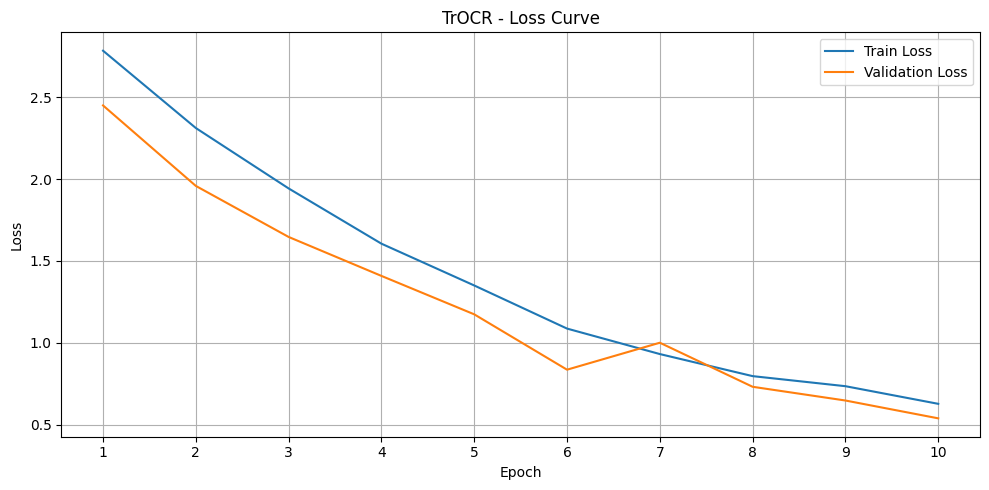

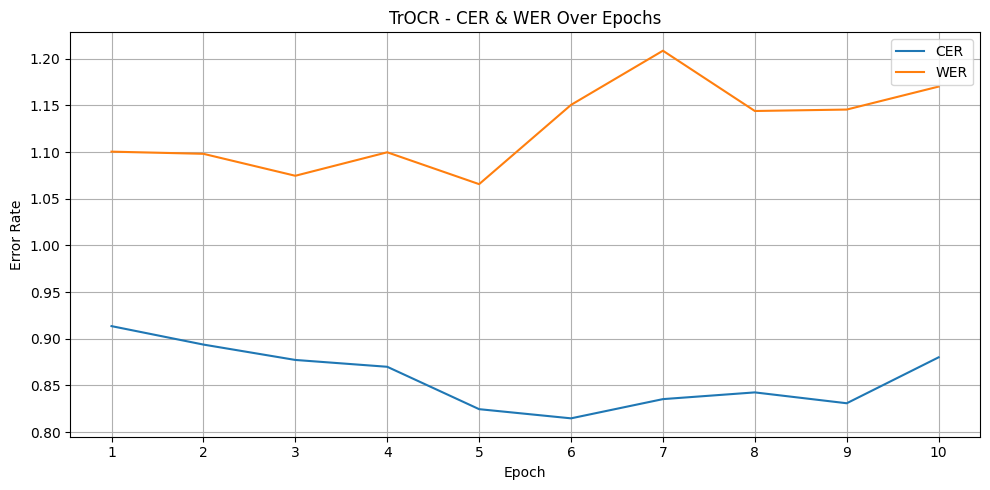

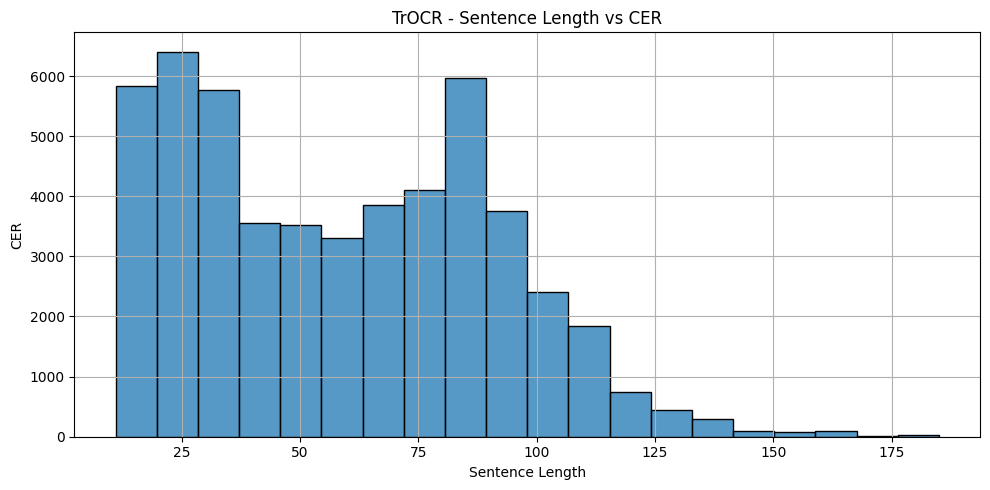

In [ ]:
# Plotting Section
# Ensuring that each epoch indexing starts from 1
epochs = list(range(1, len(train_losses_trocr) + 1))

# Loss Curve: Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_trocr, label='Train Loss')
plt.plot(epochs, val_losses_trocr, label='Validation Loss')
plt.title('TrOCR - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  CER & WER Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_trocr, label='CER')
plt.plot(epochs, wer_list_trocr, label='WER')
plt.title('TrOCR - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sentence Length vs CER
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_trocr, weights=cer_by_length_trocr, bins=20, kde=False)
plt.title('TrOCR - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

##  Baseline Model: ResNet-50 + CRNN + BiLSTM + CTC

In [ ]:
!pip install jiwer

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns

# Tracking variables
train_losses_resnet50 = []
val_losses_resnet50 = []
cer_list_resnet50 = []
wer_list_resnet50 = []
sentence_lengths_resnet50 = []
cer_by_length_resnet50 = []

class CRNN_OCR_ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.cnn = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(input_size=1024, hidden_size=256, num_layers=2,
                           bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        features = self.cnn(x)
        features = self.adaptive_pool(features).squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)
        return output

vocab_size = len(tokenizer)
model_crnn_resnet50 = CRNN_OCR_ResNet50(num_classes=vocab_size).to(device)
ctc_loss_fn_resnet50 = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_resnet50 = torch.optim.AdamW(model_crnn_resnet50.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


### Training Loop

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt

num_epochs = 20
best_model_path = "best_model_resnet50.pth"

for epoch in range(num_epochs):
    model_crnn_resnet50.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train Loop
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")
    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet50(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss_fn_resnet50(log_probs, targets, input_lengths, label_lengths)

        optimizer_resnet50.zero_grad()
        loss.backward()
        optimizer_resnet50.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet50.append(avg_train_loss)

    #  Evaluation
    model_crnn_resnet50.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet50(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = F.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn_resnet50(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())

                cer_val = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_val = wer(true_text, pred_text)

                total_cer += cer_val
                total_wer += wer_val
                sentence_lengths_resnet50.append(len(true_text))
                cer_by_length_resnet50.append(cer_val)
                sample_count += 1

    # computing Metrices
    avg_val_loss_resnet50 = total_val_loss / len(test_loader)
    avg_cer_resnet50 = total_cer / sample_count
    avg_wer_resnet50 = total_wer / sample_count

    val_losses_resnet50.append(avg_val_loss_resnet50)
    cer_list_resnet50.append(avg_cer_resnet50)
    wer_list_resnet50.append(avg_wer_resnet50)

    # Saving best ResNet50 model based on CER
    if len(cer_list_resnet50) == 1 or avg_cer_resnet50 < min(cer_list_resnet50[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet50.state_dict(),
            'optimizer_state_dict': optimizer_resnet50.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path)
        print(f"\n Saved best ResNet50 model (epoch {epoch + 1}) with CER: {avg_cer_resnet50:.4f}")

    print(f"\nResNet50 CRNN | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss_resnet50:.4f} | CER: {avg_cer_resnet50:.4f} | WER: {avg_wer_resnet50:.4f}")
    print(f"Final Scores for Epoch (ResNet50 CRNN):")
    print(f"Avg Train Loss: {train_losses_resnet50[-1]:.4f}")
    print(f"Avg Val Loss:   {val_losses_resnet50[-1]:.4f}")
    print(f"Final CER:      {cer_list_resnet50[-1]:.4f}")
    print(f"Final WER:      {wer_list_resnet50[-1]:.4f}")


Epoch 1/20


Training: 100%|██████████| 5007/5007 [06:37<00:00, 12.60batch/s, loss=0.453]



 Saved best ResNet50 model (epoch 1) with CER: 0.3678

ResNet50 CRNN | Train Loss: 1.7153 | Val Loss: 0.4509 | CER: 0.3678 | WER: 0.6736
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 1.7153
Avg Val Loss:   0.4509
Final CER:      0.3678
Final WER:      0.6736

Epoch 2/20


Training: 100%|██████████| 5007/5007 [06:33<00:00, 12.72batch/s, loss=0.0616]



 Saved best ResNet50 model (epoch 2) with CER: 0.3173

ResNet50 CRNN | Train Loss: 0.3360 | Val Loss: 0.2636 | CER: 0.3173 | WER: 0.6134
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.3360
Avg Val Loss:   0.2636
Final CER:      0.3173
Final WER:      0.6134

Epoch 3/20


Training: 100%|██████████| 5007/5007 [06:35<00:00, 12.66batch/s, loss=0.396]



ResNet50 CRNN | Train Loss: 0.2255 | Val Loss: 0.2104 | CER: 0.3373 | WER: 0.5705
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.2255
Avg Val Loss:   0.2104
Final CER:      0.3373
Final WER:      0.5705

Epoch 4/20


Training: 100%|██████████| 5007/5007 [06:35<00:00, 12.66batch/s, loss=0.0475]



ResNet50 CRNN | Train Loss: 0.1746 | Val Loss: 0.1971 | CER: 0.3539 | WER: 0.6460
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1746
Avg Val Loss:   0.1971
Final CER:      0.3539
Final WER:      0.6460

Epoch 5/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.18]



 Saved best ResNet50 model (epoch 5) with CER: 0.3136

ResNet50 CRNN | Train Loss: 0.1414 | Val Loss: 0.1680 | CER: 0.3136 | WER: 0.5559
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1414
Avg Val Loss:   0.1680
Final CER:      0.3136
Final WER:      0.5559

Epoch 6/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.129]



 Saved best ResNet50 model (epoch 6) with CER: 0.3063

ResNet50 CRNN | Train Loss: 0.1173 | Val Loss: 0.1296 | CER: 0.3063 | WER: 0.5251
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1173
Avg Val Loss:   0.1296
Final CER:      0.3063
Final WER:      0.5251

Epoch 7/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0542]



ResNet50 CRNN | Train Loss: 0.0970 | Val Loss: 0.1195 | CER: 0.3491 | WER: 0.6093
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0970
Avg Val Loss:   0.1195
Final CER:      0.3491
Final WER:      0.6093

Epoch 8/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0126]



ResNet50 CRNN | Train Loss: 0.0829 | Val Loss: 0.1044 | CER: 0.3683 | WER: 0.6350
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0829
Avg Val Loss:   0.1044
Final CER:      0.3683
Final WER:      0.6350

Epoch 9/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0209]



ResNet50 CRNN | Train Loss: 0.0711 | Val Loss: 0.1023 | CER: 0.3141 | WER: 0.5137
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0711
Avg Val Loss:   0.1023
Final CER:      0.3141
Final WER:      0.5137

Epoch 10/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.069]



ResNet50 CRNN | Train Loss: 0.0614 | Val Loss: 0.0796 | CER: 0.3477 | WER: 0.5697
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0614
Avg Val Loss:   0.0796
Final CER:      0.3477
Final WER:      0.5697

Epoch 11/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.121]



ResNet50 CRNN | Train Loss: 0.0541 | Val Loss: 0.0803 | CER: 0.3501 | WER: 0.5905
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0541
Avg Val Loss:   0.0803
Final CER:      0.3501
Final WER:      0.5905

Epoch 12/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0225]



ResNet50 CRNN | Train Loss: 0.0474 | Val Loss: 0.0709 | CER: 0.3248 | WER: 0.5482
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0474
Avg Val Loss:   0.0709
Final CER:      0.3248
Final WER:      0.5482

Epoch 13/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0395]



ResNet50 CRNN | Train Loss: 0.0420 | Val Loss: 0.0628 | CER: 0.3601 | WER: 0.6178
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0420
Avg Val Loss:   0.0628
Final CER:      0.3601
Final WER:      0.6178

Epoch 14/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0254]



ResNet50 CRNN | Train Loss: 0.0375 | Val Loss: 0.0802 | CER: 0.3284 | WER: 0.5558
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0375
Avg Val Loss:   0.0802
Final CER:      0.3284
Final WER:      0.5558

Epoch 15/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.029]



ResNet50 CRNN | Train Loss: 0.0333 | Val Loss: 0.0709 | CER: 0.3774 | WER: 0.6363
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0333
Avg Val Loss:   0.0709
Final CER:      0.3774
Final WER:      0.6363

Epoch 16/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.00384]



ResNet50 CRNN | Train Loss: 0.0326 | Val Loss: 0.0556 | CER: 0.3563 | WER: 0.5960
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0326
Avg Val Loss:   0.0556
Final CER:      0.3563
Final WER:      0.5960

Epoch 17/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0774]



ResNet50 CRNN | Train Loss: 0.0285 | Val Loss: 0.0657 | CER: 0.3384 | WER: 0.6000
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0285
Avg Val Loss:   0.0657
Final CER:      0.3384
Final WER:      0.6000

Epoch 18/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0153]



ResNet50 CRNN | Train Loss: 0.0266 | Val Loss: 0.0626 | CER: 0.3583 | WER: 0.6062
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0266
Avg Val Loss:   0.0626
Final CER:      0.3583
Final WER:      0.6062

Epoch 19/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.0302]



ResNet50 CRNN | Train Loss: 0.0243 | Val Loss: 0.0505 | CER: 0.3702 | WER: 0.6340
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0243
Avg Val Loss:   0.0505
Final CER:      0.3702
Final WER:      0.6340

Epoch 20/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.00475]



ResNet50 CRNN | Train Loss: 0.0220 | Val Loss: 0.0583 | CER: 0.3883 | WER: 0.6203
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0220
Avg Val Loss:   0.0583
Final CER:      0.3883
Final WER:      0.6203


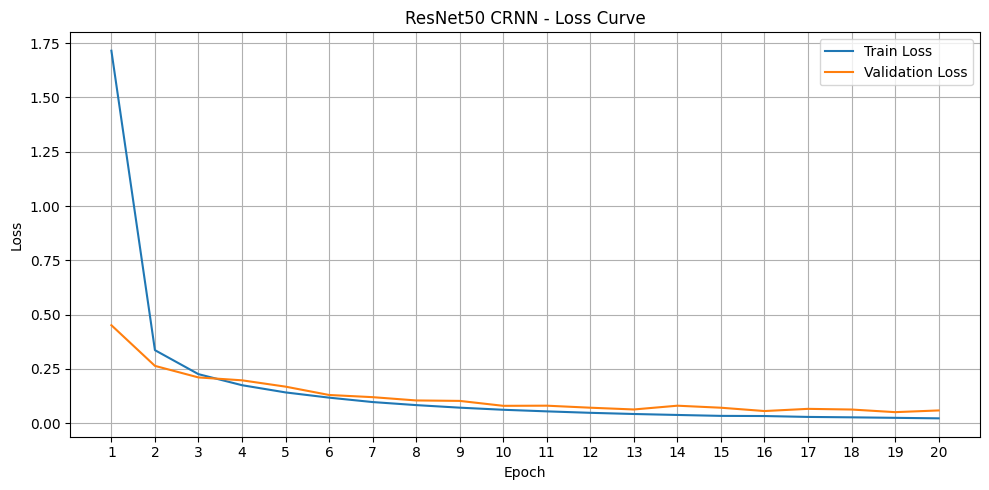

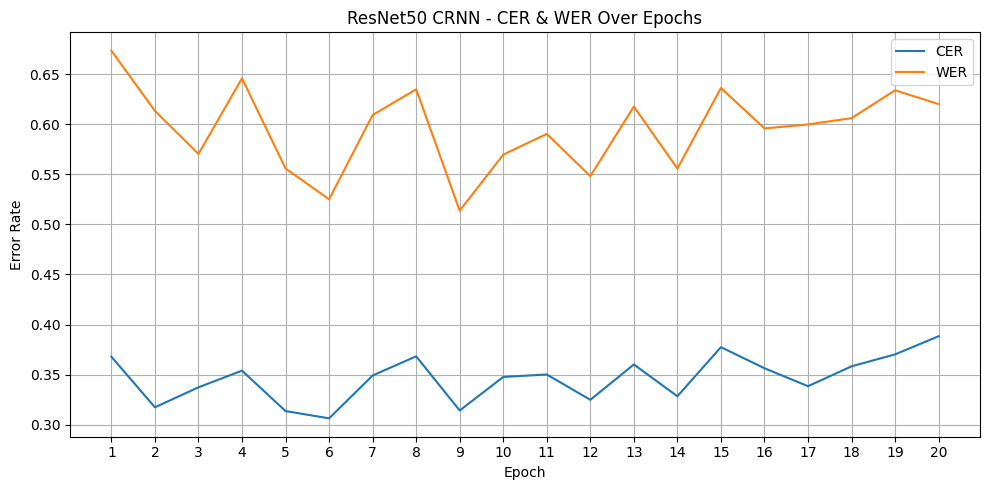

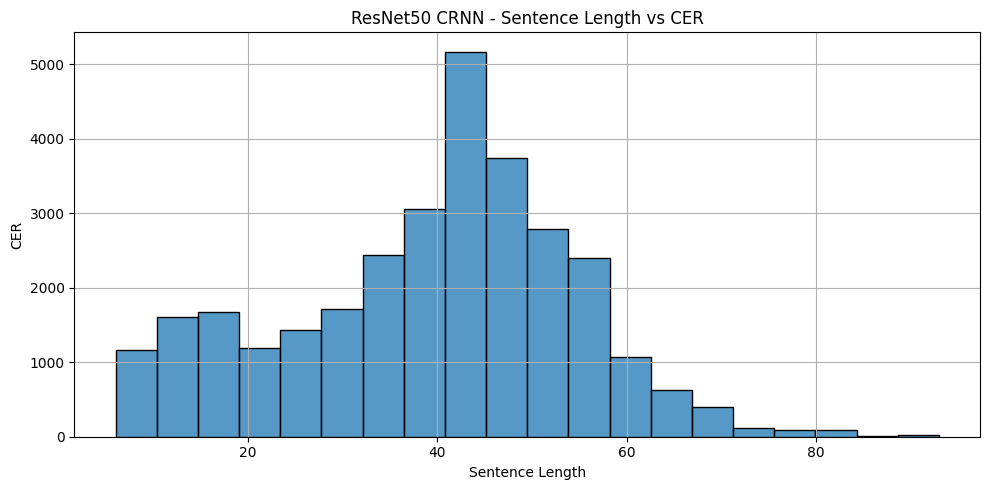

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring epoch indexing starts from 1
epochs = list(range(1, len(train_losses_resnet50) + 1))

#  Loss Curve : Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet50, label='Train Loss')
plt.plot(epochs, val_losses_resnet50, label='Validation Loss')
plt.title('ResNet50 CRNN - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CER & WER over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet50, label='CER')
plt.plot(epochs, wer_list_resnet50, label='WER')
plt.title('ResNet50 CRNN - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sentence Length vs CER
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet50, weights=cer_by_length_resnet50, bins=20, kde=False)
plt.title('ResNet50 CRNN - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Checking 10 random samples : predicted and groundtruth

In [ ]:
from jiwer import cer

total_cer_resnet50 = 0
sample_count_resnet50 = 0

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet50(images)  # [W, B, C]
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet50 >= 10:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, decoded)
            total_cer_resnet50 += cer_score

            print(f"Predicted: {decoded}")
            print(f"Actual   : {target_text}")
            print(f"CER      : {cer_score:.3f}")
            print("----")

            sample_count_resnet50 += 1

        if sample_count_resnet50 >= 10:
            break

avg_cer_resnet50 = total_cer_resnet50 / sample_count_resnet50
print(f"\nAverage CER (ResNet50) over {sample_count_resnet50} samples: {avg_cer_resnet50:.3f}")

Predicted: <hi>  कााल  ममें  अररब  के  अमीरर  ममुल्क़़  भी  करर्ज़़  लेने  पर  हुुए
Actual   : <hi> काल में अरब के अमीर मुल्क़ भी कर्ज़ लेने पर हुए
CER      : 0.385
----
Predicted: <hi>  ट््ररंप:  ललगतताा है किि  अदााललतेंं भी  सििियााससीी  हो गगई
Actual   : <hi> ट्रंप: लगता है कि अदालतें भी सियासी हो गई
CER      : 0.435
----
Predicted: <hi>  वर्ल्ड  कप   20019:  ऑसस्ट्रेलिियाा  ने  वेस्टइंंडीज़़  कोो ररनोंं सेे
Actual   : <hi> वर्ल्ड कप 2019: ऑस्ट्रेलिया ने वेस्टइंडीज़ को रनों से
CER      : 0.310
----
Predicted: <en> thee  year  thee  ministeer  wroote  ppersonallly to  some  two
Actual   : <en> the year the minister wrote personally to some two
CER      : 0.236
----
Predicted: <hi>  रूूस  ककी  योजननााा   पर   पी--5  देेशोंं  ककी
Actual   : <hi> रूस की योजना पर पी-5 देशों की
CER      : 0.529
----
Predicted: <en>  rreecoord     anyway
Actual   : <en> record  anyway
CER      : 0.368
----
Predicted: <en> a lot   of  iit  iis   mmeviitaabble  sso  tthat   iinndustrry   annd
Actual   : <en

## Baseline Model: ResNet-101 + CRNN + BiLSTM + CTC

In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.5 MB/s eta 0:00:00


In [4]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns

# Tracking variables
train_losses_resnet101 = []
val_losses_resnet101 = []
cer_list_resnet101 = []
wer_list_resnet101 = []
sentence_lengths_resnet101 = []
cer_by_length_resnet101 = []


class CRNN_OCR_ResNet101(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet101, self).__init__()

        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-3]  # Keep up to conv4_x
        self.cnn = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

        self.rnn = nn.LSTM(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # Grayscale to RGB
        features = self.cnn(x)
        features = self.adaptive_pool(features)
        features = features.squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)  # [W, B, num_classes]
        return output


In [ ]:
vocab_size = len(tokenizer)
model_crnn_resnet101 = CRNN_OCR_ResNet101(num_classes=vocab_size).to(device)

ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_crnn_resnet101 = torch.optim.AdamW(model_crnn_resnet101.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_crnn_resnet101, mode='min', factor=0.5, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 228MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.war

In [ ]:
from tqdm import tqdm
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt

num_epochs = 20 #number of epochs to train the model
best_model_path = "best_model_resnet101.pth"

for epoch in range(num_epochs):
    model_crnn_resnet101.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")

    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet101(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)

        optimizer_crnn_resnet101.zero_grad()
        loss.backward()
        optimizer_crnn_resnet101.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet101.append(avg_train_loss)

    model_crnn_resnet101.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet101(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())
                cer_score = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_score = wer(true_text, pred_text)

                total_cer += cer_score
                total_wer += wer_score
                sentence_lengths_resnet101.append(len(true_text))
                cer_by_length_resnet101.append(cer_score)
                sample_count += 1

    # computing metrices
    avg_val_loss = total_val_loss / len(test_loader)
    avg_cer = total_cer / sample_count
    avg_wer = total_wer / sample_count

    val_losses_resnet101.append(avg_val_loss)
    cer_list_resnet101.append(avg_cer)
    wer_list_resnet101.append(avg_wer)

    scheduler.step(avg_val_loss)

    # Save best model based on CER
    if len(cer_list_resnet101) == 1 or avg_cer < min(cer_list_resnet101[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet101.state_dict(),
            'optimizer_state_dict': optimizer_crnn_resnet101.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path)
        print(f"\n Saved best model (epoch {epoch + 1}) with CER: {avg_cer:.4f}")

    print(f"ResNet101 CRNN | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")
    print(f"\nFinal Scores (ResNet101 CRNN):")
    print(f"Avg Train Loss: {train_losses_resnet101[-1]:.4f}")
    print(f"Avg Val Loss:   {val_losses_resnet101[-1]:.4f}")
    print(f"Final CER:      {cer_list_resnet101[-1]:.4f}")
    print(f"Final WER:      {wer_list_resnet101[-1]:.4f}")


Epoch 1/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.173]



 Saved best model (epoch 1) with CER: 0.3402
ResNet101 CRNN | Train Loss: 1.4164 | Val Loss: 0.3703 | CER: 0.3402 | WER: 0.5907

Final Scores (ResNet101 CRNN):
Avg Train Loss: 1.4164
Avg Val Loss:   0.3703
Final CER:      0.3402
Final WER:      0.5907

Epoch 2/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.444]



 Saved best model (epoch 2) with CER: 0.3259
ResNet101 CRNN | Train Loss: 0.3064 | Val Loss: 0.2571 | CER: 0.3259 | WER: 0.5583

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.3064
Avg Val Loss:   0.2571
Final CER:      0.3259
Final WER:      0.5583

Epoch 3/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.253]


ResNet101 CRNN | Train Loss: 0.2311 | Val Loss: 0.2161 | CER: 0.3265 | WER: 0.5441

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.2311
Avg Val Loss:   0.2161
Final CER:      0.3265
Final WER:      0.5441

Epoch 4/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.224]



 Saved best model (epoch 4) with CER: 0.2850
ResNet101 CRNN | Train Loss: 0.1886 | Val Loss: 0.1983 | CER: 0.2850 | WER: 0.4777

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1886
Avg Val Loss:   0.1983
Final CER:      0.2850
Final WER:      0.4777

Epoch 5/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.114]



 Saved best model (epoch 5) with CER: 0.2612
ResNet101 CRNN | Train Loss: 0.1621 | Val Loss: 0.1740 | CER: 0.2612 | WER: 0.5182

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1621
Avg Val Loss:   0.1740
Final CER:      0.2612
Final WER:      0.5182

Epoch 6/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.277]


ResNet101 CRNN | Train Loss: 0.1387 | Val Loss: 0.1530 | CER: 0.2868 | WER: 0.4850

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1387
Avg Val Loss:   0.1530
Final CER:      0.2868
Final WER:      0.4850

Epoch 7/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.107]


ResNet101 CRNN | Train Loss: 0.1190 | Val Loss: 0.1380 | CER: 0.2939 | WER: 0.5315

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1190
Avg Val Loss:   0.1380
Final CER:      0.2939
Final WER:      0.5315

Epoch 8/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0688]


ResNet101 CRNN | Train Loss: 0.1015 | Val Loss: 0.1157 | CER: 0.2780 | WER: 0.4029

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1015
Avg Val Loss:   0.1157
Final CER:      0.2780
Final WER:      0.4029

Epoch 9/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0559]


ResNet101 CRNN | Train Loss: 0.0849 | Val Loss: 0.1043 | CER: 0.3434 | WER: 0.4998

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0849
Avg Val Loss:   0.1043
Final CER:      0.3434
Final WER:      0.4998

Epoch 10/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.54batch/s, loss=0.0611]


ResNet101 CRNN | Train Loss: 0.0752 | Val Loss: 0.1065 | CER: 0.3214 | WER: 0.5297

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0752
Avg Val Loss:   0.1065
Final CER:      0.3214
Final WER:      0.5297

Epoch 11/20


Training: 100%|██████████| 5007/5007 [08:45<00:00,  9.53batch/s, loss=0.12]


ResNet101 CRNN | Train Loss: 0.0651 | Val Loss: 0.0957 | CER: 0.3427 | WER: 0.5309

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0651
Avg Val Loss:   0.0957
Final CER:      0.3427
Final WER:      0.5309

Epoch 12/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.0219]


ResNet101 CRNN | Train Loss: 0.0571 | Val Loss: 0.0849 | CER: 0.3291 | WER: 0.5211

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0571
Avg Val Loss:   0.0849
Final CER:      0.3291
Final WER:      0.5211

Epoch 13/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0863]


ResNet101 CRNN | Train Loss: 0.0482 | Val Loss: 0.0748 | CER: 0.2873 | WER: 0.4448

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0482
Avg Val Loss:   0.0748
Final CER:      0.2873
Final WER:      0.4448

Epoch 14/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0261]


ResNet101 CRNN | Train Loss: 0.0448 | Val Loss: 0.0843 | CER: 0.2985 | WER: 0.4454

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0448
Avg Val Loss:   0.0843
Final CER:      0.2985
Final WER:      0.4454

Epoch 15/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.145]


ResNet101 CRNN | Train Loss: 0.0414 | Val Loss: 0.0674 | CER: 0.3457 | WER: 0.5118

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0414
Avg Val Loss:   0.0674
Final CER:      0.3457
Final WER:      0.5118

Epoch 16/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0228]


ResNet101 CRNN | Train Loss: 0.0360 | Val Loss: 0.0548 | CER: 0.3160 | WER: 0.5038

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0360
Avg Val Loss:   0.0548
Final CER:      0.3160
Final WER:      0.5038

Epoch 17/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.271]


ResNet101 CRNN | Train Loss: 0.0304 | Val Loss: 0.0573 | CER: 0.3245 | WER: 0.4734

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0304
Avg Val Loss:   0.0573
Final CER:      0.3245
Final WER:      0.4734

Epoch 18/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.00112]


ResNet101 CRNN | Train Loss: 0.0286 | Val Loss: 0.0493 | CER: 0.3335 | WER: 0.4678

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0286
Avg Val Loss:   0.0493
Final CER:      0.3335
Final WER:      0.4678

Epoch 19/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.183]


ResNet101 CRNN | Train Loss: 0.0279 | Val Loss: 0.0462 | CER: 0.3371 | WER: 0.4990

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0279
Avg Val Loss:   0.0462
Final CER:      0.3371
Final WER:      0.4990

Epoch 20/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.56batch/s, loss=0.105]


ResNet101 CRNN | Train Loss: 0.0241 | Val Loss: 0.0503 | CER: 0.3855 | WER: 0.5842

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0241
Avg Val Loss:   0.0503
Final CER:      0.3855
Final WER:      0.5842


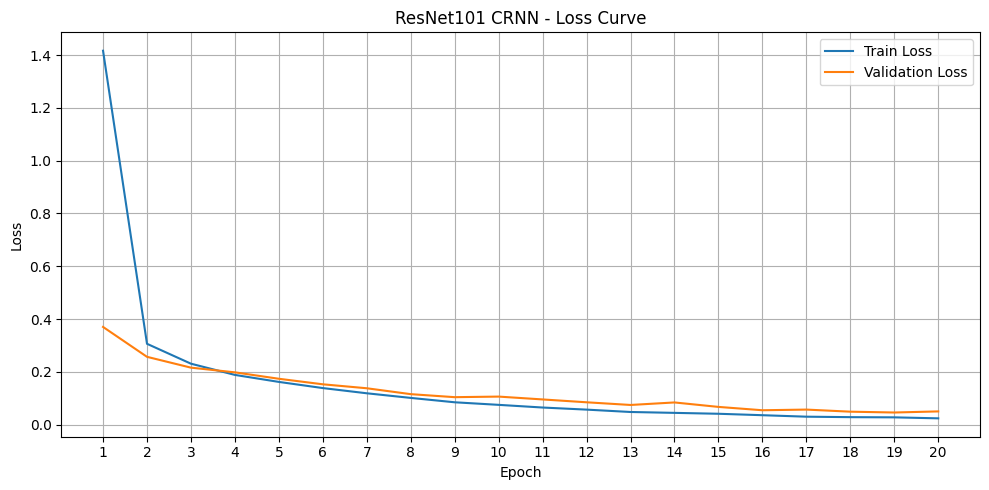

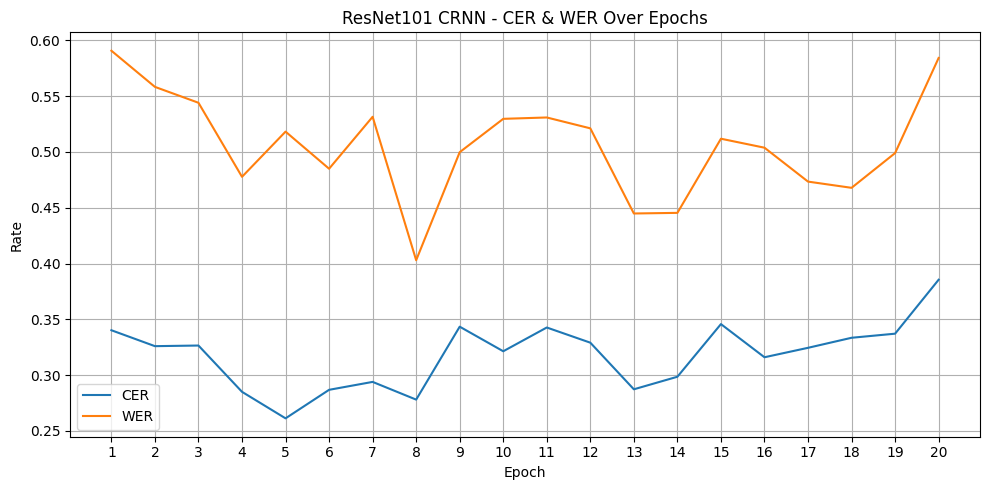

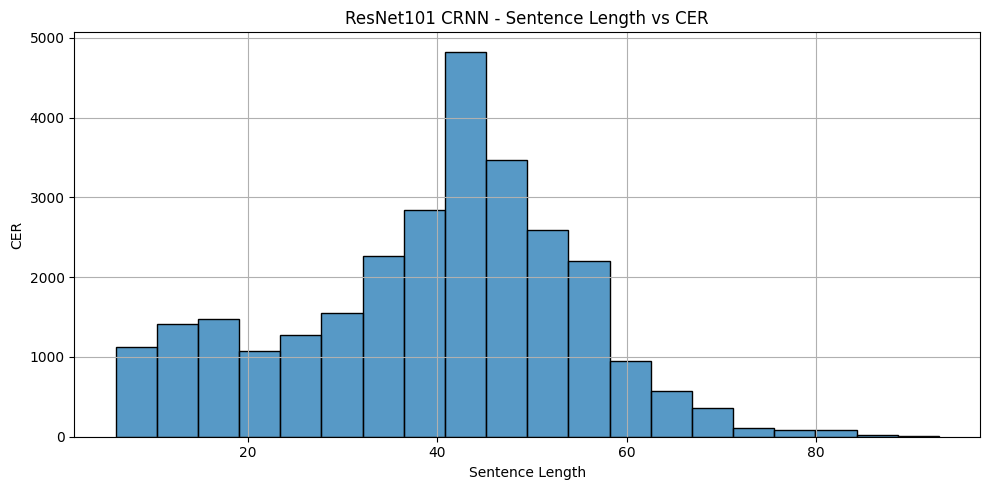

In [ ]:
# Making graphs for the training and validation losses, CER, and WER and sentence length vs CER

import matplotlib.pyplot as plt
import seaborn as sns

#ensuring the number of epoch startes from 1 to avoid confusion
epochs = list(range(1, len(train_losses_resnet101) + 1))

# Loss Curve : Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet101, label='Train Loss')
plt.plot(epochs, val_losses_resnet101, label='Validation Loss')
plt.title('ResNet101 CRNN - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  CER and WER over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet101, label='CER')
plt.plot(epochs, wer_list_resnet101, label='WER')
plt.title('ResNet101 CRNN - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sentence Length vs CER

plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet101, weights=cer_by_length_resnet101, bins=20, kde=False)
plt.title('ResNet101 CRNN - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Checking 10 random samples prediction with groundtruth

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import cer

total_cer_resnet101 = 0
sample_count_resnet101 = 0

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet101(images)  # [W, B, C]
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet101 >= 10:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, decoded)
            total_cer_resnet101 += cer_score

            print(f"Predicted: {decoded}")
            print(f"Actual   : {target_text}")
            print(f"CER      : {cer_score:.3f}")
            print("----")

            sample_count_resnet101 += 1

        if sample_count_resnet101 >= 10:
            break

avg_cer_resnet101 = total_cer_resnet101 / sample_count_resnet101
print(f"\nAverage CER (ResNet101) over {sample_count_resnet101} samples: {avg_cer_resnet101:.3f}")

Predicted: <en> enggland  annnd   has  made   it   liive
Actual   : <en> england and has made it live
CER      : 0.364
----
Predicted: <en> ennd    the  manufacture   and  use   oof
Actual   : <en> end the manufacture and use of
CER      : 0.314
----
Predicted: <en> iiincrreased  majorriitiiiers
Actual   : <en> increased majorities
CER      : 0.360
----
Predicted: <en>>  tthee
Actual   : <en> the
CER      : 0.500
----
Predicted: <en> wwhiich   lleeft   iits  ceentrraal  ccharracter   and   tthe
Actual   : <en> which left its central character and the
CER      : 0.467
----
Predicted: <en> hiis  face   was  fiiixeed
Actual   : <en> his face was fixed
CER      : 0.348
----
Predicted: <en> mrr  bryan   stonehousses   prooductiion   is   quieently
Actual   : <en> mr bryan stonehouses production is quietly
CER      : 0.319
----
Predicted: <en> thaar  a   human   beeingg    had  an  increasing  numbeer  oof  dissciplees  amonngg
Actual   : <en> than a human being   had an increasing number of

## Final Model: ResNet-101 + CRNN + BiLSTM + CTC with symspellpy

In [5]:
!pip install jiwer

In [6]:
# Install and download dictionary
!pip install symspellpy
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt

# Import and initialization
from symspellpy import SymSpell, Verbosity

# Initializing the SymSpell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Loading the dictionary
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 16.5 MB/s eta 0:00:00
--2025-05-04 19:31:33--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.007s  

2025-05-04 19:31:34 (188 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332881/1332881]



True

In [7]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
from tqdm import tqdm
from symspellpy import SymSpell, Verbosity
import re

# Tracking variables
train_losses_resnet101_v2 = []
val_losses_resnet101_v2 = []
cer_list_resnet101_v2 = []
wer_list_resnet101_v2 = []
sentence_lengths_resnet101_v2 = []
cer_by_length_resnet101_v2 = []

# SymSpell Setup
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


# tag pattern for avioiding the tags so that symspell wont mess up with the tags
TAG_PATTERN = re.compile(r'^<*<?\s*(hi|hii|en)\s*>*>>*$', re.IGNORECASE)

def symspell_correct(text):
    tokens = text.strip().split()

    if not tokens:
        return text

    first_token = tokens[0].lower()

    # If Hindi tag detected , skip
    if "hi" in first_token:
        return text

    corrected = []
    for i, word in enumerate(tokens):
        # Preserving the tokens
        if TAG_PATTERN.match(word.lower()):
            corrected.append(word)
            continue

        # Apply correction
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected.append(suggestions[0].term if suggestions else word)

    return ' '.join(corrected)


class CRNN_OCR_ResNet101_v2(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet101_v2, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-3]  # keep to conv4x
        self.cnn = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # converting back from grayscale to RGB
        features = self.cnn(x)
        features = self.adaptive_pool(features)
        features = features.squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)
        return output

In [ ]:
vocab_size = len(tokenizer)
model_crnn_resnet101_v2 = CRNN_OCR_ResNet101_v2(num_classes=vocab_size).to(device)

ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_crnn_resnet101_v2 = torch.optim.AdamW(model_crnn_resnet101_v2.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_crnn_resnet101_v2, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 20 # number of epochs for tarining
best_model_path_v2 = "best_model_resnet101_v2.pth"

for epoch in range(num_epochs):
    model_crnn_resnet101_v2.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")

    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet101_v2(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)

        optimizer_crnn_resnet101_v2.zero_grad()
        loss.backward()
        optimizer_crnn_resnet101_v2.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet101_v2.append(avg_train_loss)

    model_crnn_resnet101_v2.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet101_v2(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = F.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                pred_text = symspell_correct(pred_text)  # <- Post-correction
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())

                cer_score = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_score = wer(true_text, pred_text)

                total_cer += cer_score
                total_wer += wer_score
                sentence_lengths_resnet101_v2.append(len(true_text))
                cer_by_length_resnet101_v2.append(cer_score)
                sample_count += 1

    avg_val_loss = total_val_loss / len(test_loader)
    avg_cer = total_cer / sample_count
    avg_wer = total_wer / sample_count

    val_losses_resnet101_v2.append(avg_val_loss)
    cer_list_resnet101_v2.append(avg_cer)
    wer_list_resnet101_v2.append(avg_wer)

    scheduler.step(avg_val_loss)

    if len(cer_list_resnet101_v2) == 1 or avg_cer < min(cer_list_resnet101_v2[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet101_v2.state_dict(),
            'optimizer_state_dict': optimizer_crnn_resnet101_v2.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path_v2)
        print(f"\n  Saved best model (epoch {epoch + 1}) with CER: {avg_cer:.4f}")

    print(f"ResNet101 CRNN v2 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")
    print(f"\nFinal Scores (ResNet101 CRNN v2):")
    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Avg Val Loss:   {avg_val_loss:.4f}")
    print(f"Final CER:      {avg_cer:.4f}")
    print(f"Final WER:      {avg_wer:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/20


Training: 100%|██████████| 5007/5007 [08:50<00:00,  9.44batch/s, loss=0.517]



  Saved best model (epoch 1) with CER: 0.2268
ResNet101 CRNN v2 | Train Loss: 1.4752 | Val Loss: 0.3861 | CER: 0.2268 | WER: 0.4559

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 1.4752
Avg Val Loss:   0.3861
Final CER:      0.2268
Final WER:      0.4559

Epoch 2/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.325]



  Saved best model (epoch 2) with CER: 0.1778
ResNet101 CRNN v2 | Train Loss: 0.3095 | Val Loss: 0.2577 | CER: 0.1778 | WER: 0.4132

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.3095
Avg Val Loss:   0.2577
Final CER:      0.1778
Final WER:      0.4132

Epoch 3/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.50batch/s, loss=0.168]


ResNet101 CRNN v2 | Train Loss: 0.2270 | Val Loss: 0.2213 | CER: 0.2142 | WER: 0.4459

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.2270
Avg Val Loss:   0.2213
Final CER:      0.2142
Final WER:      0.4459

Epoch 4/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.0927]


ResNet101 CRNN v2 | Train Loss: 0.1886 | Val Loss: 0.2149 | CER: 0.1866 | WER: 0.4206

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1886
Avg Val Loss:   0.2149
Final CER:      0.1866
Final WER:      0.4206

Epoch 5/20


Training: 100%|██████████| 5007/5007 [08:49<00:00,  9.45batch/s, loss=0.302]



  Saved best model (epoch 5) with CER: 0.1576
ResNet101 CRNN v2 | Train Loss: 0.1564 | Val Loss: 0.2087 | CER: 0.1576 | WER: 0.3832

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1564
Avg Val Loss:   0.2087
Final CER:      0.1576
Final WER:      0.3832

Epoch 6/20


Training: 100%|██████████| 5007/5007 [08:51<00:00,  9.43batch/s, loss=0.0361]



  Saved best model (epoch 6) with CER: 0.1387
ResNet101 CRNN v2 | Train Loss: 0.1335 | Val Loss: 0.1427 | CER: 0.1387 | WER: 0.3160

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1335
Avg Val Loss:   0.1427
Final CER:      0.1387
Final WER:      0.3160

Epoch 7/20


Training: 100%|██████████| 5007/5007 [08:46<00:00,  9.52batch/s, loss=0.398]


ResNet101 CRNN v2 | Train Loss: 0.1127 | Val Loss: 0.1245 | CER: 0.1503 | WER: 0.3656

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1127
Avg Val Loss:   0.1245
Final CER:      0.1503
Final WER:      0.3656

Epoch 8/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0304]


ResNet101 CRNN v2 | Train Loss: 0.1002 | Val Loss: 0.1153 | CER: 0.1453 | WER: 0.3461

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1002
Avg Val Loss:   0.1153
Final CER:      0.1453
Final WER:      0.3461

Epoch 9/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.206]


ResNet101 CRNN v2 | Train Loss: 0.0867 | Val Loss: 0.1088 | CER: 0.1624 | WER: 0.3854

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0867
Avg Val Loss:   0.1088
Final CER:      0.1624
Final WER:      0.3854

Epoch 10/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.47batch/s, loss=0.115]


ResNet101 CRNN v2 | Train Loss: 0.0757 | Val Loss: 0.0880 | CER: 0.1440 | WER: 0.3220

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0757
Avg Val Loss:   0.0880
Final CER:      0.1440
Final WER:      0.3220

Epoch 11/20


Training: 100%|██████████| 5007/5007 [08:52<00:00,  9.40batch/s, loss=0.0459]



  Saved best model (epoch 11) with CER: 0.1252
ResNet101 CRNN v2 | Train Loss: 0.0659 | Val Loss: 0.0854 | CER: 0.1252 | WER: 0.2836

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0659
Avg Val Loss:   0.0854
Final CER:      0.1252
Final WER:      0.2836

Epoch 12/20


Training: 100%|██████████| 5007/5007 [08:49<00:00,  9.46batch/s, loss=0.055]


ResNet101 CRNN v2 | Train Loss: 0.0572 | Val Loss: 0.0699 | CER: 0.1259 | WER: 0.3086

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0572
Avg Val Loss:   0.0699
Final CER:      0.1259
Final WER:      0.3086

Epoch 13/20


Training: 100%|██████████| 5007/5007 [08:46<00:00,  9.50batch/s, loss=0.0441]


ResNet101 CRNN v2 | Train Loss: 0.0527 | Val Loss: 0.0734 | CER: 0.1422 | WER: 0.3373

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0527
Avg Val Loss:   0.0734
Final CER:      0.1422
Final WER:      0.3373

Epoch 14/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.50batch/s, loss=0.148]


ResNet101 CRNN v2 | Train Loss: 0.0475 | Val Loss: 0.0670 | CER: 0.1475 | WER: 0.3157

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0475
Avg Val Loss:   0.0670
Final CER:      0.1475
Final WER:      0.3157

Epoch 15/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0298]


ResNet101 CRNN v2 | Train Loss: 0.0411 | Val Loss: 0.0738 | CER: 0.1368 | WER: 0.3110

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0411
Avg Val Loss:   0.0738
Final CER:      0.1368
Final WER:      0.3110

Epoch 16/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0156]


ResNet101 CRNN v2 | Train Loss: 0.0386 | Val Loss: 0.0568 | CER: 0.1388 | WER: 0.3130

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0386
Avg Val Loss:   0.0568
Final CER:      0.1388
Final WER:      0.3130

Epoch 17/20


Training: 100%|██████████| 5007/5007 [08:53<00:00,  9.39batch/s, loss=0.136]


ResNet101 CRNN v2 | Train Loss: 0.0363 | Val Loss: 0.0813 | CER: 0.1426 | WER: 0.3141

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0363
Avg Val Loss:   0.0813
Final CER:      0.1426
Final WER:      0.3141

Epoch 18/20


Training: 100%|██████████| 5007/5007 [08:50<00:00,  9.43batch/s, loss=0.359]


ResNet101 CRNN v2 | Train Loss: 0.0289 | Val Loss: 0.0738 | CER: 0.1314 | WER: 0.2916

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0289
Avg Val Loss:   0.0738
Final CER:      0.1314
Final WER:      0.2916

Epoch 19/20


Training: 100%|██████████| 5007/5007 [08:52<00:00,  9.40batch/s, loss=0.0208]


ResNet101 CRNN v2 | Train Loss: 0.0289 | Val Loss: 0.0545 | CER: 0.1370 | WER: 0.3104

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0289
Avg Val Loss:   0.0545
Final CER:      0.1370
Final WER:      0.3104

Epoch 20/20


Training: 100%|██████████| 5007/5007 [08:51<00:00,  9.41batch/s, loss=0.0213]


ResNet101 CRNN v2 | Train Loss: 0.0272 | Val Loss: 0.0439 | CER: 0.1333 | WER: 0.2900

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0272
Avg Val Loss:   0.0439
Final CER:      0.1333
Final WER:      0.2900


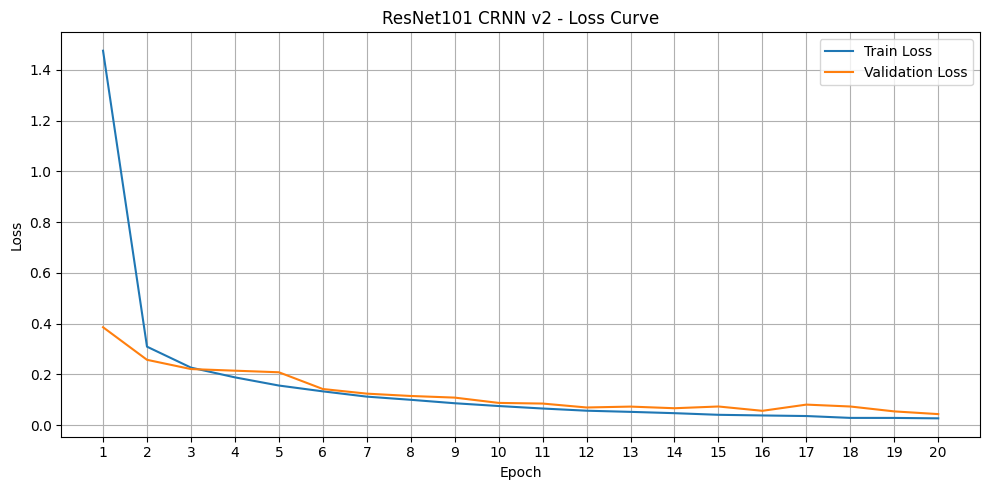

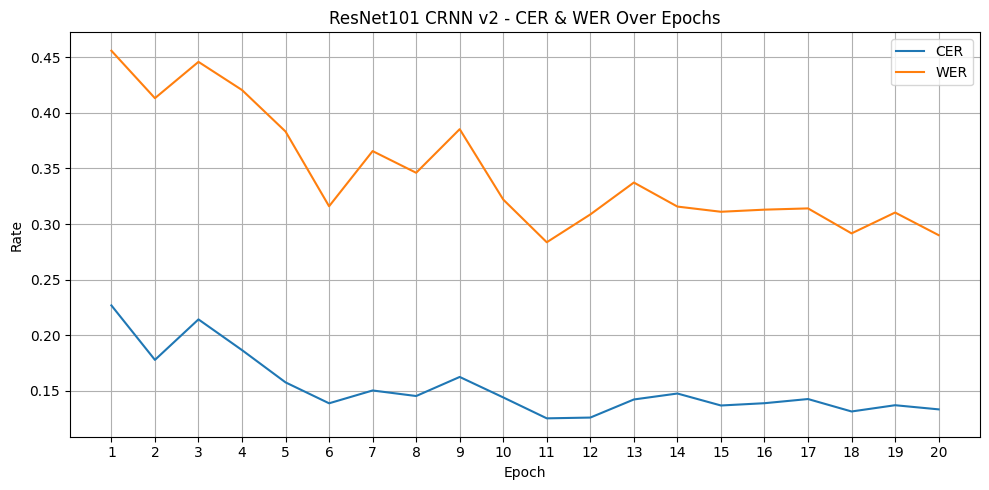

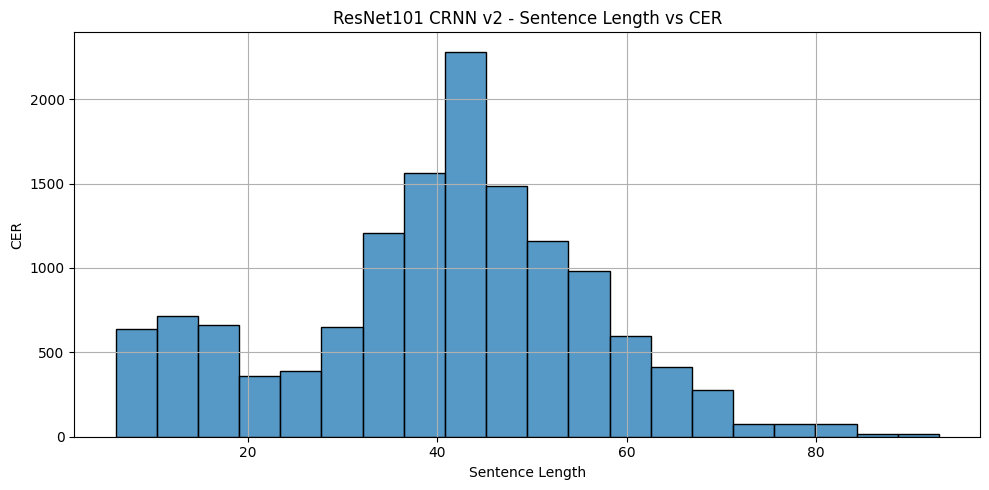

In [ ]:
# Plotting Section

import matplotlib.pyplot as plt
import seaborn as sns

#ensuring that the epoch in plot starts from 1 to avoid confusion
epochs = list(range(1, len(train_losses_resnet101_v2) + 1))

# Loss Curve : Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet101_v2, label='Train Loss')
plt.plot(epochs, val_losses_resnet101_v2, label='Validation Loss')
plt.title('ResNet101 CRNN v2 - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CER and WER over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet101_v2, label='CER')
plt.plot(epochs, wer_list_resnet101_v2, label='WER')
plt.title('ResNet101 CRNN v2 - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Sentence Length vs CER
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet101_v2, weights=cer_by_length_resnet101_v2, bins=20, kde=False)
plt.title('ResNet101 CRNN v2 - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Printing the 10 random samples predicted and groundtruth

In [ ]:
from jiwer import cer

total_cer_resnet101_v2 = 0
sample_count_resnet101_v2 = 0
sample_limit = 10

print("\n Sample Predictions (CRNN ResNet101 v2):\n")

model_crnn_resnet101_v2.eval()

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet101_v2(images)
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet101_v2 >= sample_limit:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            corrected = symspell_correct(decoded)
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, corrected)
            total_cer_resnet101_v2 += cer_score

            print(f"Predicted : {corrected}")
            print(f"Actual    : {target_text}")
            print(f"CER       : {cer_score:.3f}")
            print("-" * 40)

            sample_count_resnet101_v2 += 1

        if sample_count_resnet101_v2 >= sample_limit:
            break

avg_cer_resnet101_v2 = total_cer_resnet101_v2 / sample_count_resnet101_v2
print(f"\n Average CER (ResNet101 v2) over {sample_count_resnet101_v2} samples: {avg_cer_resnet101_v2:.3f}")


 Sample Predictions (CRNN ResNet101 v2):

Predicted : <hi>  ककााल  मेंं अरब  कके  अमीरर  मुुल्फ़़ भीी  ककर््ज़  लेनेे  पर हुुए
Actual    : <hi> काल में अरब के अमीर मुल्क़ भी कर्ज़ लेने पर हुए
CER       : 0.404
----------------------------------------
Predicted : <hi>  ट््ररंप::  ललगततताा  हैै  ककिि  अदाालतें  भीी  सिियाासी  हो  गईई
Actual    : <hi> ट्रंप: लगता है कि अदालतें भी सियासी हो गई
CER       : 0.522
----------------------------------------
Predicted : <hi>  वर्ल्ड ककप  2019: ऑस्ट्रेलियाा  ने  वेसस्टइंडीीज़़  को  रनों  से
Actual    : <hi> वर्ल्ड कप 2019: ऑस्ट्रेलिया ने वेस्टइंडीज़ को रनों से
CER       : 0.207
----------------------------------------
Predicted : <en> thee year ﻿the minister wrote personally to some two
Actual    : <en> the year the minister wrote personally to some two
CER       : 0.036
----------------------------------------
Predicted : <hi>  रूूस  कीी  योजनाा   पर  पीी--5 देेशोों कीी
Actual    : <hi> रूस की योजना पर पी-5 देशों की
CER       : 0.412
-----------